<a href="https://colab.research.google.com/github/Altemir1/Crypto-DL-Based-Trading-System/blob/main/sentiment_analysis_on_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Collection

Import dataset from the hugging face datasets

In [2]:
import pandas as pd

df = pd.read_csv("hf://datasets/edaschau/bitcoin_news/BTC_yahoo.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df.head()

,time_unix,date_time,text_matches,title_matches,title,url,source,source_url,article_text
0,1308740160,2011-06-22 10:56:00+00:00,"{""Bitcoin"": [0, 967, 1184, 1227]}","{""Bitcoin"": [37]}",Compromised account leads to massive Bitcoin s...,https://finance.yahoo.com/news/2011-06-22-comp...,Engadget,https://www.engadget.com/,"Bitcoin, for those not aware, is a completely ..."
1,1328119352,2012-02-01 18:02:32+00:00,"{""Bitcoin"": [18, 195, 1871, 2827, 3683]}","{""Bitcoin"": [0]}",Bitcoin May Be The Currency Of The Future,https://finance.yahoo.com/news/bitcoin-may-cur...,Investopedia,http://www.investopedia.com/,Have you heard of Bitcoin? If you're a fan of ...
2,1332444236,2012-03-22 19:23:56+00:00,"{""Bitcoin"": [562, 705, 981, 1064, 2068, 2221, ...","{""Bitcoin"": [56]}",Should Africa Adopt a Shared Currency? And Sho...,https://finance.yahoo.com/news/africa-adopt-sh...,The Atlantic,http://www.theatlantic.com/,Dekstop /Flickr I wrote on Monday about Sweden...
3,1345679880,2012-08-22 23:58:00+00:00,"{""Bitcoin"": [450]}",{},"MasterCard denies BitCoin card rumors, BitInst...",https://finance.yahoo.com/news/2012-08-22-mast...,Engadget,https://www.engadget.com/,MasterCard shoots down BitCoin debit card rumo...
4,1347025081,2012-09-07 13:38:01+00:00,"{""Bitcoin"": [1231, 5352]}",{},Claim of Romney taxes theft a puzzling whodunit,https://finance.yahoo.com/news/claim-romney-ta...,Associated Press,https://apnews.com/,"WASHINGTON (AP) — Assuming it's not a hoax, th..."


In [4]:
df_selected_features = df[["date_time", "title", "source"]]
df_selected_features.head()

,date_time,title,source
0,2011-06-22 10:56:00+00:00,Compromised account leads to massive Bitcoin s...,Engadget
1,2012-02-01 18:02:32+00:00,Bitcoin May Be The Currency Of The Future,Investopedia
2,2012-03-22 19:23:56+00:00,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic
3,2012-08-22 23:58:00+00:00,"MasterCard denies BitCoin card rumors, BitInst...",Engadget
4,2012-09-07 13:38:01+00:00,Claim of Romney taxes theft a puzzling whodunit,Associated Press


In [5]:
df_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80806 entries, 0 to 80805
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_time  80806 non-null  object
 1   title      80806 non-null  object
 2   source     80806 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [6]:
btc_news = df_selected_features.copy()

In [7]:
split_df = btc_news["date_time"].str.split(" ")
btc_news["date"] = split_df.str[0]
btc_news["time"] = split_df.str[1]

btc_news.head()

,date_time,title,source,date,time
0,2011-06-22 10:56:00+00:00,Compromised account leads to massive Bitcoin s...,Engadget,2011-06-22,10:56:00+00:00
1,2012-02-01 18:02:32+00:00,Bitcoin May Be The Currency Of The Future,Investopedia,2012-02-01,18:02:32+00:00
2,2012-03-22 19:23:56+00:00,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic,2012-03-22,19:23:56+00:00
3,2012-08-22 23:58:00+00:00,"MasterCard denies BitCoin card rumors, BitInst...",Engadget,2012-08-22,23:58:00+00:00
4,2012-09-07 13:38:01+00:00,Claim of Romney taxes theft a puzzling whodunit,Associated Press,2012-09-07,13:38:01+00:00


In [8]:
btc_news["date"] = pd.to_datetime(btc_news["date"], format="%Y-%m-%d")
btc_news["date"]

,date
0,2011-06-22
1,2012-02-01
2,2012-03-22
3,2012-08-22
4,2012-09-07
...,...
80801,2024-01-24
80802,2024-01-24
80803,2024-01-24
80804,2024-01-24


In [9]:
btc_news.drop(columns=["time", "date_time"], inplace=True)

Assigning sentiment score to the article titles

In [10]:
!pip install transformers

Importing necessary libraries

In [11]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import torch

Check if GPU available

In [12]:
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")


Using device: GPU


In [13]:
# Load the FinBERT model with GPU support
model_name = "ProsusAI/finbert"
finbert_pipeline = pipeline("sentiment-analysis", model=model_name, batch_size=64, device=device)  # Increased batch_size

# Convert titles to a list for batch processing
titles = btc_news['title'].tolist()

# Define batch size (Increase for faster processing if GPU memory allows)
batch_size = 64

# Store results
results = []

# Process in batches
for i in tqdm(range(0, len(titles), batch_size), desc="Processing Batches with GPU"):
    batch = titles[i:i+batch_size]
    try:
        result_batch = finbert_pipeline(batch)
        results.extend(result_batch)
    except Exception as e:
        print(f"Error processing batch {i} to {i+batch_size}: {str(e)}")
        results.extend([{'label': None, 'score': None}] * len(batch))

# Convert results to DataFrame columns
btc_news['finbert_sentiment'] = [r['label'] if r else None for r in results]
btc_news['finbert_score'] = [r['score'] if r else None for r in results]

# Save the updated DataFrame to a new CSV file
btc_news.to_csv('bitcoin_articles_with_finbert_sentiment.csv', index=False)

print("Processing completed successfully!")

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0

Processing Batches with GPU:   1%|          | 10/1263 [00:02<03:19,  6.28it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

Processing Batches with GPU: 100%|██████████| 1263/1263 [02:46<00:00,  7.57it/s]


Processing completed successfully!


In [14]:
btc_news.head()

,title,source,date,finbert_sentiment,finbert_score
0,Compromised account leads to massive Bitcoin s...,Engadget,2011-06-22,negative,0.801531
1,Bitcoin May Be The Currency Of The Future,Investopedia,2012-02-01,neutral,0.899791
2,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic,2012-03-22,neutral,0.919918
3,"MasterCard denies BitCoin card rumors, BitInst...",Engadget,2012-08-22,neutral,0.906358
4,Claim of Romney taxes theft a puzzling whodunit,Associated Press,2012-09-07,neutral,0.567120


In [16]:
btc_news.finbert_sentiment.value_counts()

,count
finbert_sentiment,
neutral,45883
negative,18445
positive,16478


In [17]:
btc_news.source.value_counts()

,count
source,
CoinDesk,13393
FX Empire,8021
Motley Fool,5646
Reuters,5376
InvestorPlace,3970
...,...
WHIO,1
Guitar World,1
WPXI,1


## EDA

In [2]:
import pandas as pd

df = pd.read_csv("/content/bitcoin_articles_with_finbert_sentiment.csv")
df.head()

,title,source,date,finbert_sentiment,finbert_score
0,Compromised account leads to massive Bitcoin s...,Engadget,2011-06-22,negative,0.801531
1,Bitcoin May Be The Currency Of The Future,Investopedia,2012-02-01,neutral,0.899791
2,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic,2012-03-22,neutral,0.919918
3,"MasterCard denies BitCoin card rumors, BitInst...",Engadget,2012-08-22,neutral,0.906358
4,Claim of Romney taxes theft a puzzling whodunit,Associated Press,2012-09-07,neutral,0.567120


Proprotion of publisher on bitcoin

In [3]:
articles_df = df["source"].value_counts()
percentage = (articles_df / articles_df.sum()) * 100

In [4]:
def group_articles(row, percentage):
  if percentage[row["source"]] < 3:
    return "Other"
  else:
    return row["source"]

grouped_articles = df.apply(lambda row: group_articles(row, percentage), axis=1)
grouped_articles.value_counts()

,count
Other,32648
CoinDesk,13393
FX Empire,8021
Motley Fool,5646
Reuters,5376
InvestorPlace,3970
GlobeNewswire,3578
Business Insider,2955
Benzinga,2703
CCN,2516


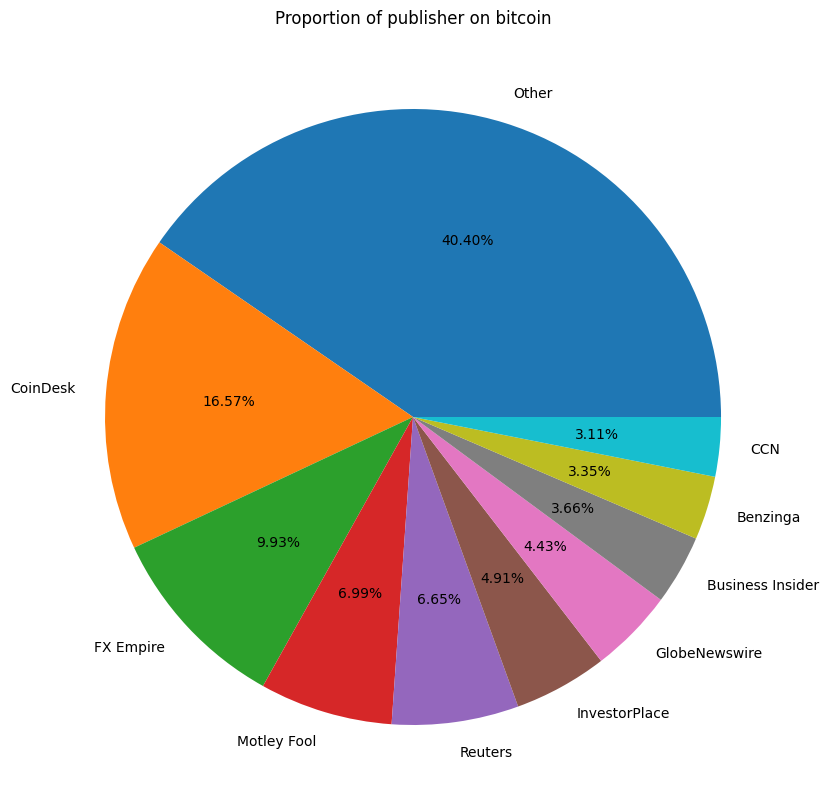

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

visualize_articles = grouped_articles.value_counts()
plt.figure(figsize =(20, 10))
plt.pie(visualize_articles, labels = visualize_articles.index, autopct = "%.2f%%")
plt.title("Proportion of publisher on bitcoin")
plt.show()



Prorortion of the news according to the months by sentiment

In [10]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["date"]

,date
0,2011-06-22
1,2012-02-01
2,2012-03-22
3,2012-08-22
4,2012-09-07
...,...
80801,2024-01-24
80802,2024-01-24
80803,2024-01-24
80804,2024-01-24


In [12]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
group_by_year = df.groupby(["year", "month", "finbert_sentiment"]).size().reset_index(name="count")
group_by_year

,year,month,finbert_sentiment,count
0,2011,6,negative,1
1,2012,2,neutral,1
2,2012,3,neutral,1
3,2012,8,neutral,1
4,2012,9,neutral,2
...,...,...,...,...
396,2023,12,neutral,324
397,2023,12,positive,185
398,2024,1,negative,450
399,2024,1,neutral,638


In [25]:
group_by_year['month_total'] = group_by_year.groupby(['year', 'month'])['count'].transform('sum')
group_by_year['proportion'] = group_by_year['count'] / group_by_year['month_total']

In [14]:
btc = pd.read_csv("BTC.csv")
btc.head()

,date,ticker,open,high,low,close,volume
0,2010-07-14,BTC,0.058157,0.061588,0.048647,0.056402,261.54
1,2010-07-15,BTC,0.056403,0.067954,0.053969,0.057568,445.80
2,2010-07-16,BTC,0.058001,0.072220,0.057484,0.066492,497.25
3,2010-07-17,BTC,0.066500,0.077735,0.057418,0.065993,19.99
4,2010-07-18,BTC,0.066088,0.080858,0.064221,0.078814,75.13


In [15]:
btc["date"] = pd.to_datetime(btc["date"])

In [16]:
btc = btc.sort_values(by="date")

In [19]:
btc["year"] = btc["date"].dt.year
btc["month"] = btc["date"].dt.month

In [21]:
monthly_change = btc.groupby(['year', 'month'])['close'].agg(['first', 'last']).reset_index()
monthly_change['percent_change'] = ((monthly_change['last'] - monthly_change['first']) / monthly_change['first']) * 100

In [22]:
monthly_change

,year,month,first,last,percent_change
0,2010,7,0.056402,0.069759,23.681168
1,2010,8,0.060465,0.068038,12.525180
2,2010,9,0.062748,0.061866,-1.406180
3,2010,10,0.060423,0.191777,217.392334
4,2010,11,0.196296,0.215672,9.871050
...,...,...,...,...,...
173,2024,12,97279.792922,93429.202811,-3.958263
174,2025,1,94419.757505,102405.027084,8.457202
175,2025,2,100655.905651,84373.010330,-16.176791
176,2025,3,86031.912398,82548.910961,-4.048499


In [38]:
monthly_change[monthly_change["year"] == 2012]

,year,month,first,last,percent_change
18,2012,1,5.132450,5.549653,8.128734
19,2012,2,5.756635,4.964563,-13.759291
20,2012,3,4.920173,4.889310,-0.627279
21,2012,4,4.913760,4.988361,1.518207
22,2012,5,5.000000,5.180003,3.600067
23,2012,6,5.227209,6.681077,27.813473
24,2012,7,6.656567,9.333153,40.209709
25,2012,8,9.504037,10.764336,13.260670
26,2012,9,10.353905,12.486069,20.592856
27,2012,10,12.428733,11.103216,-10.664940


In [24]:
years = df["year"].unique()
years

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024], dtype=int32)

In [34]:
# Pivotting table with proportion of sentiments
pivot = group_by_year[group_by_year['year'] == 2012].pivot_table(
    index='month',
    columns='finbert_sentiment',
    values='proportion',
    fill_value = 0)

# Ensure all three sentiment columns exist
for sentiment in ['negative', 'neutral', 'positive']:
    if sentiment not in pivot.columns:
        pivot[sentiment] = 0


pivot = pivot[['negative', 'neutral', 'positive']]

months = pivot.index.tolist()
negative_vals = pivot['negative'].tolist()
neutral_vals = pivot['neutral'].tolist()
positive_vals = pivot['positive'].tolist()

pivot


finbert_sentiment,negative,neutral,positive
month,,,
2,0,1.0,0
3,0,1.0,0
8,0,1.0,0
9,0,1.0,0
10,0,1.0,0
11,0,1.0,0
12,0,1.0,0


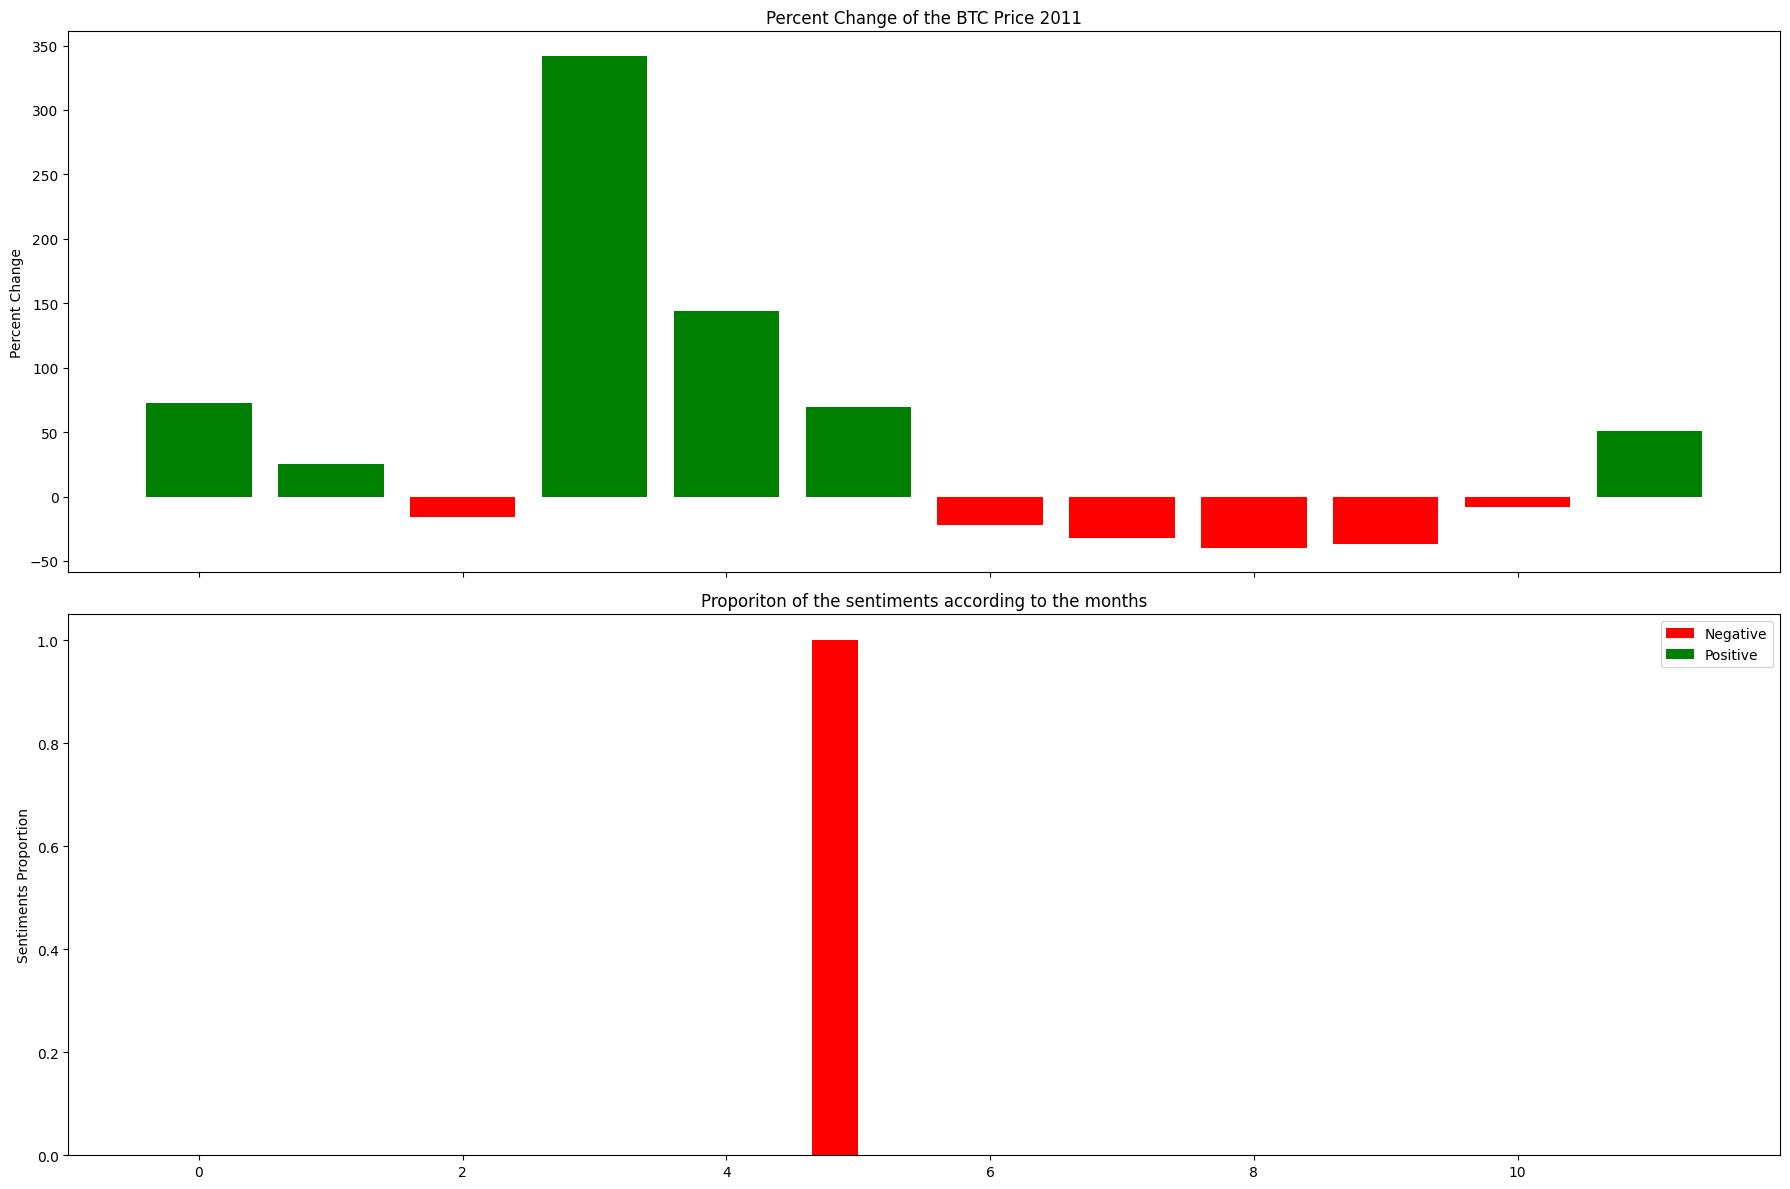

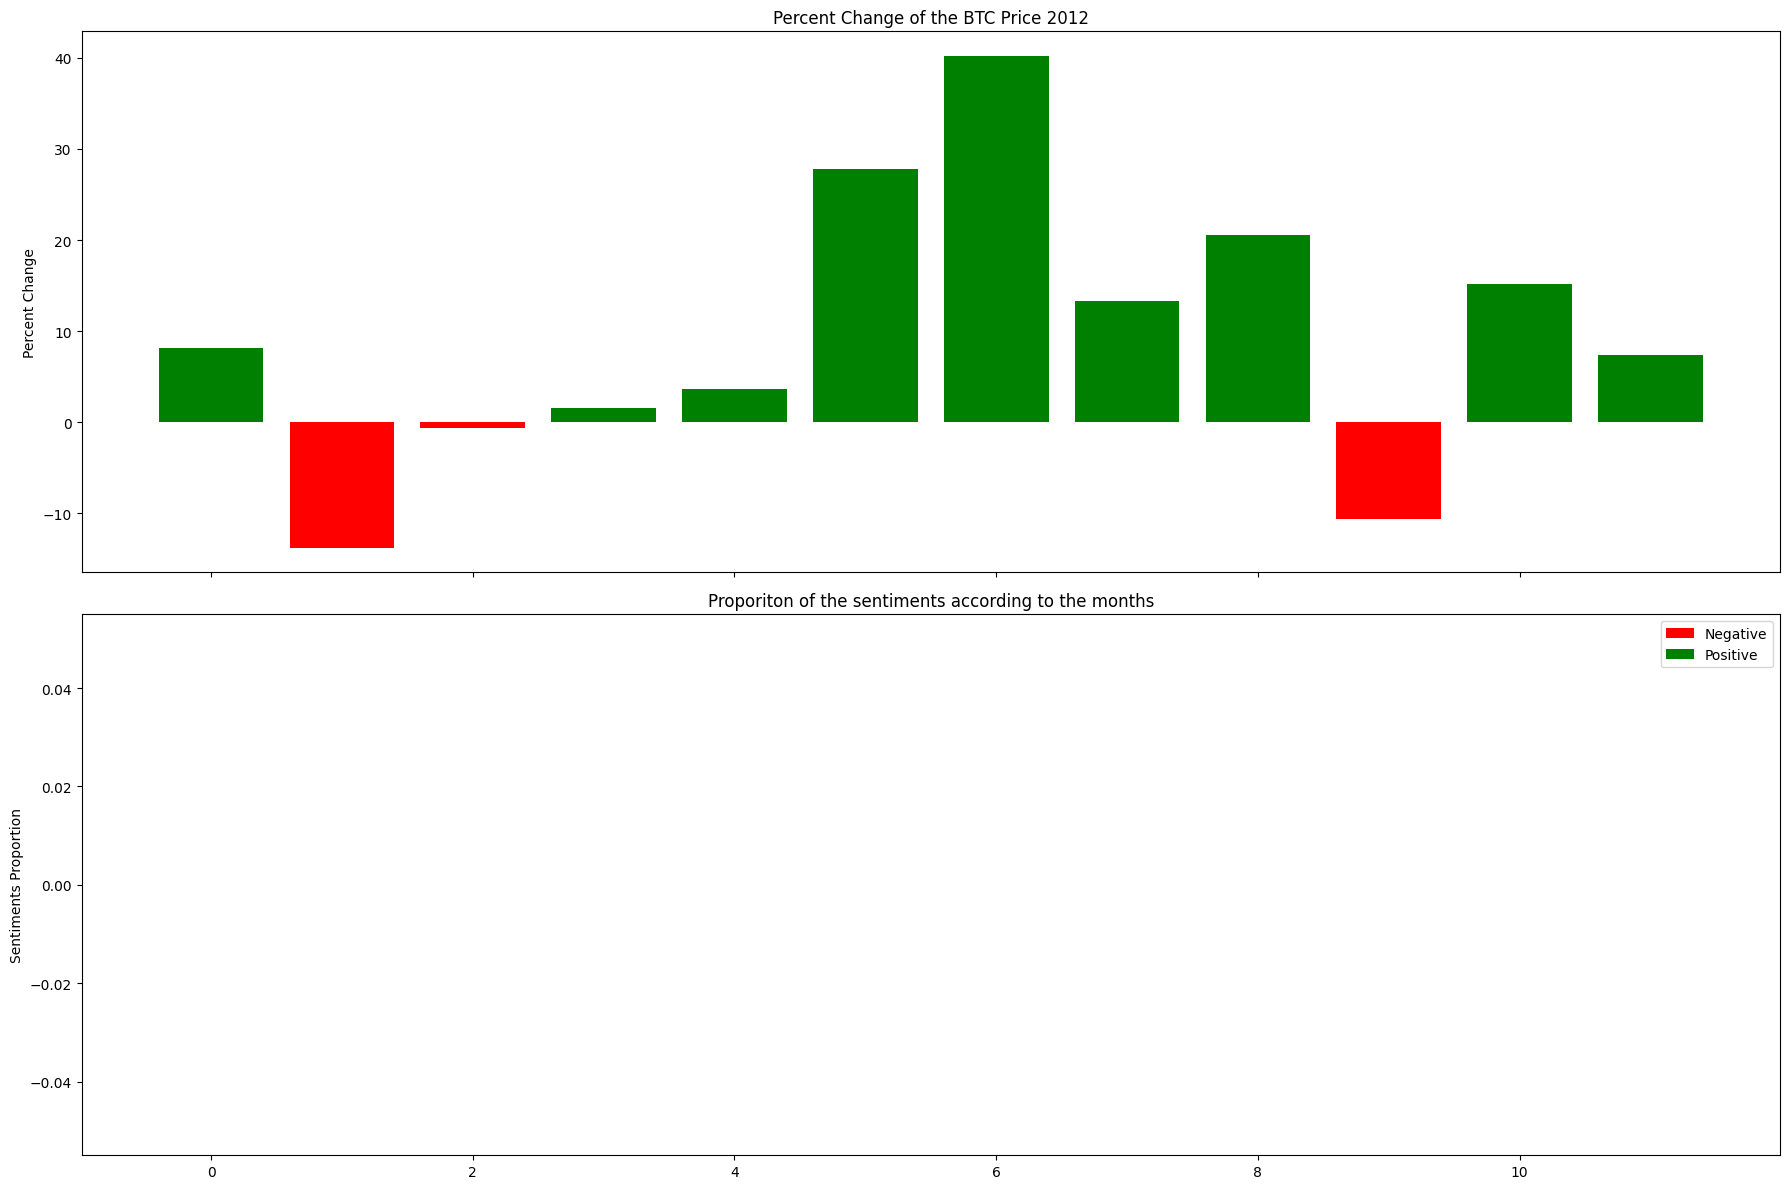

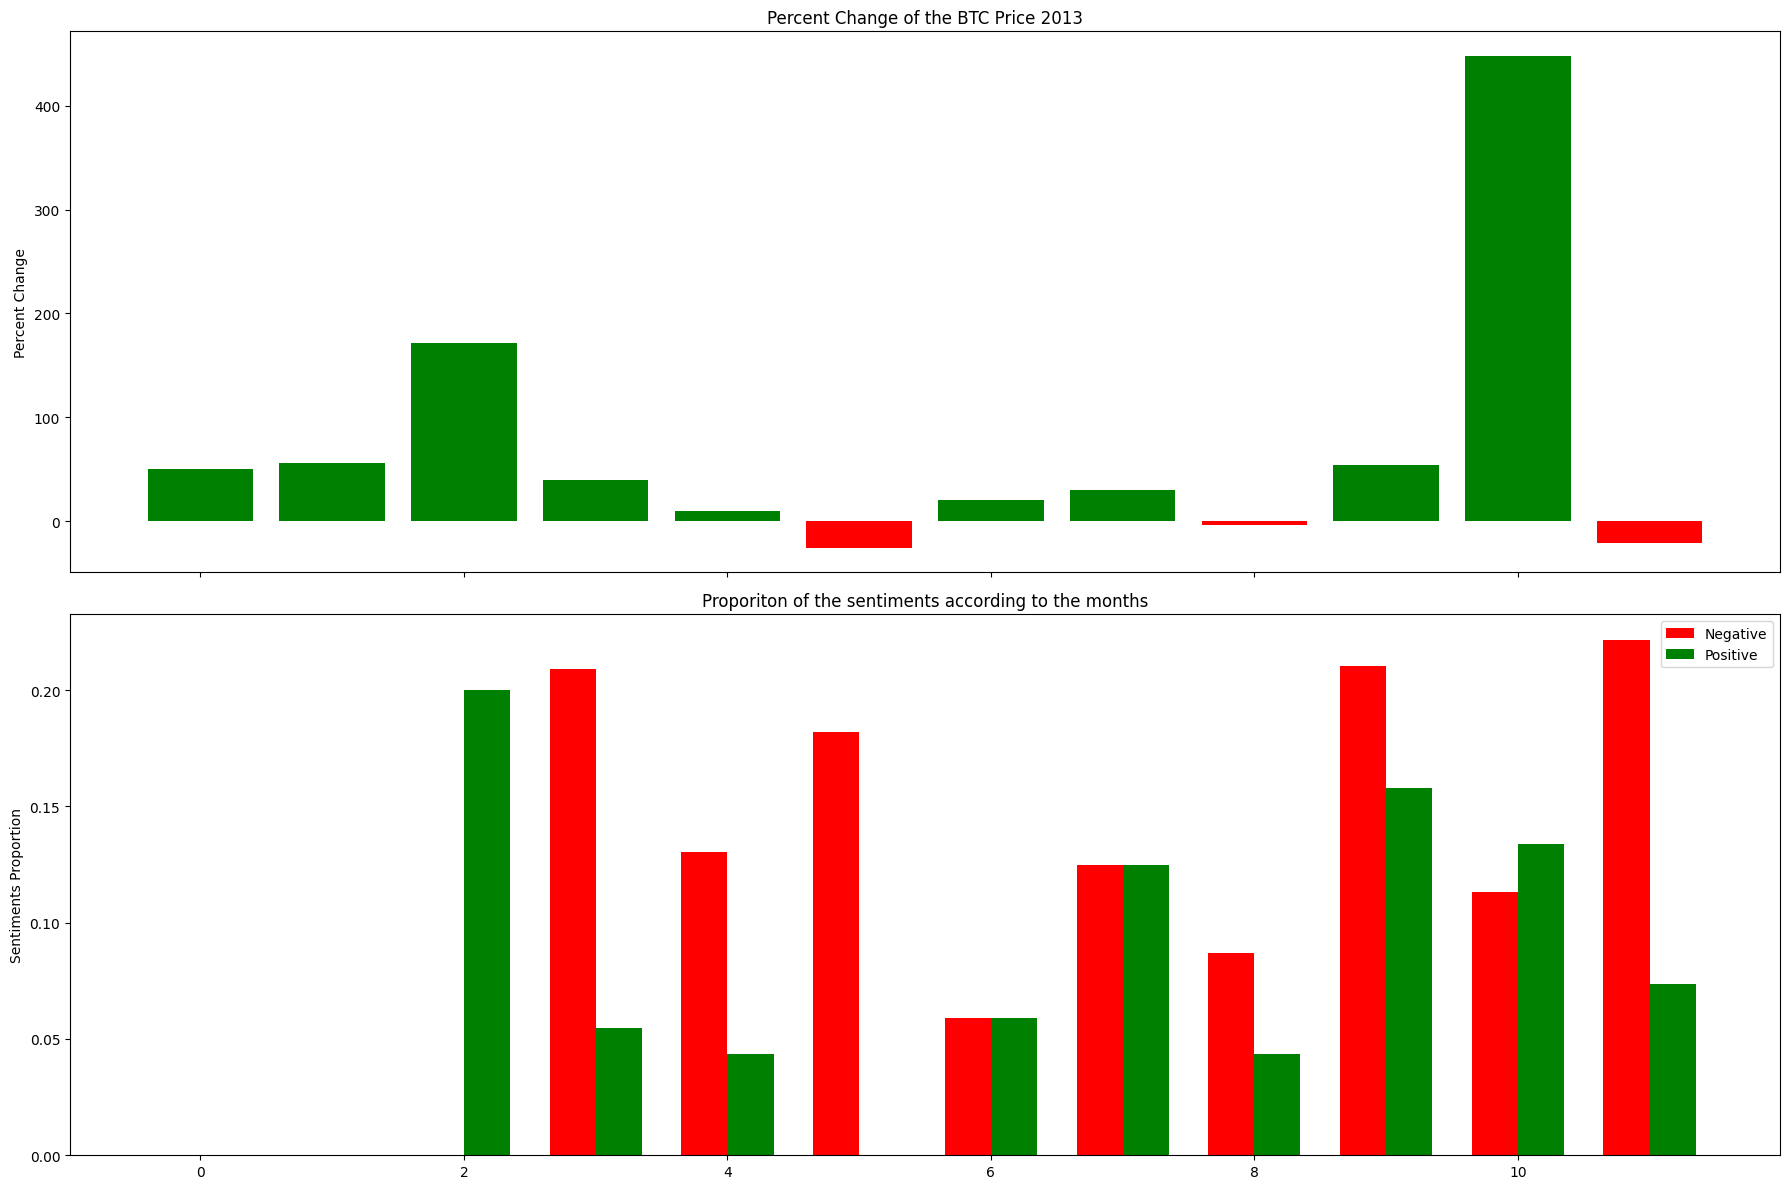

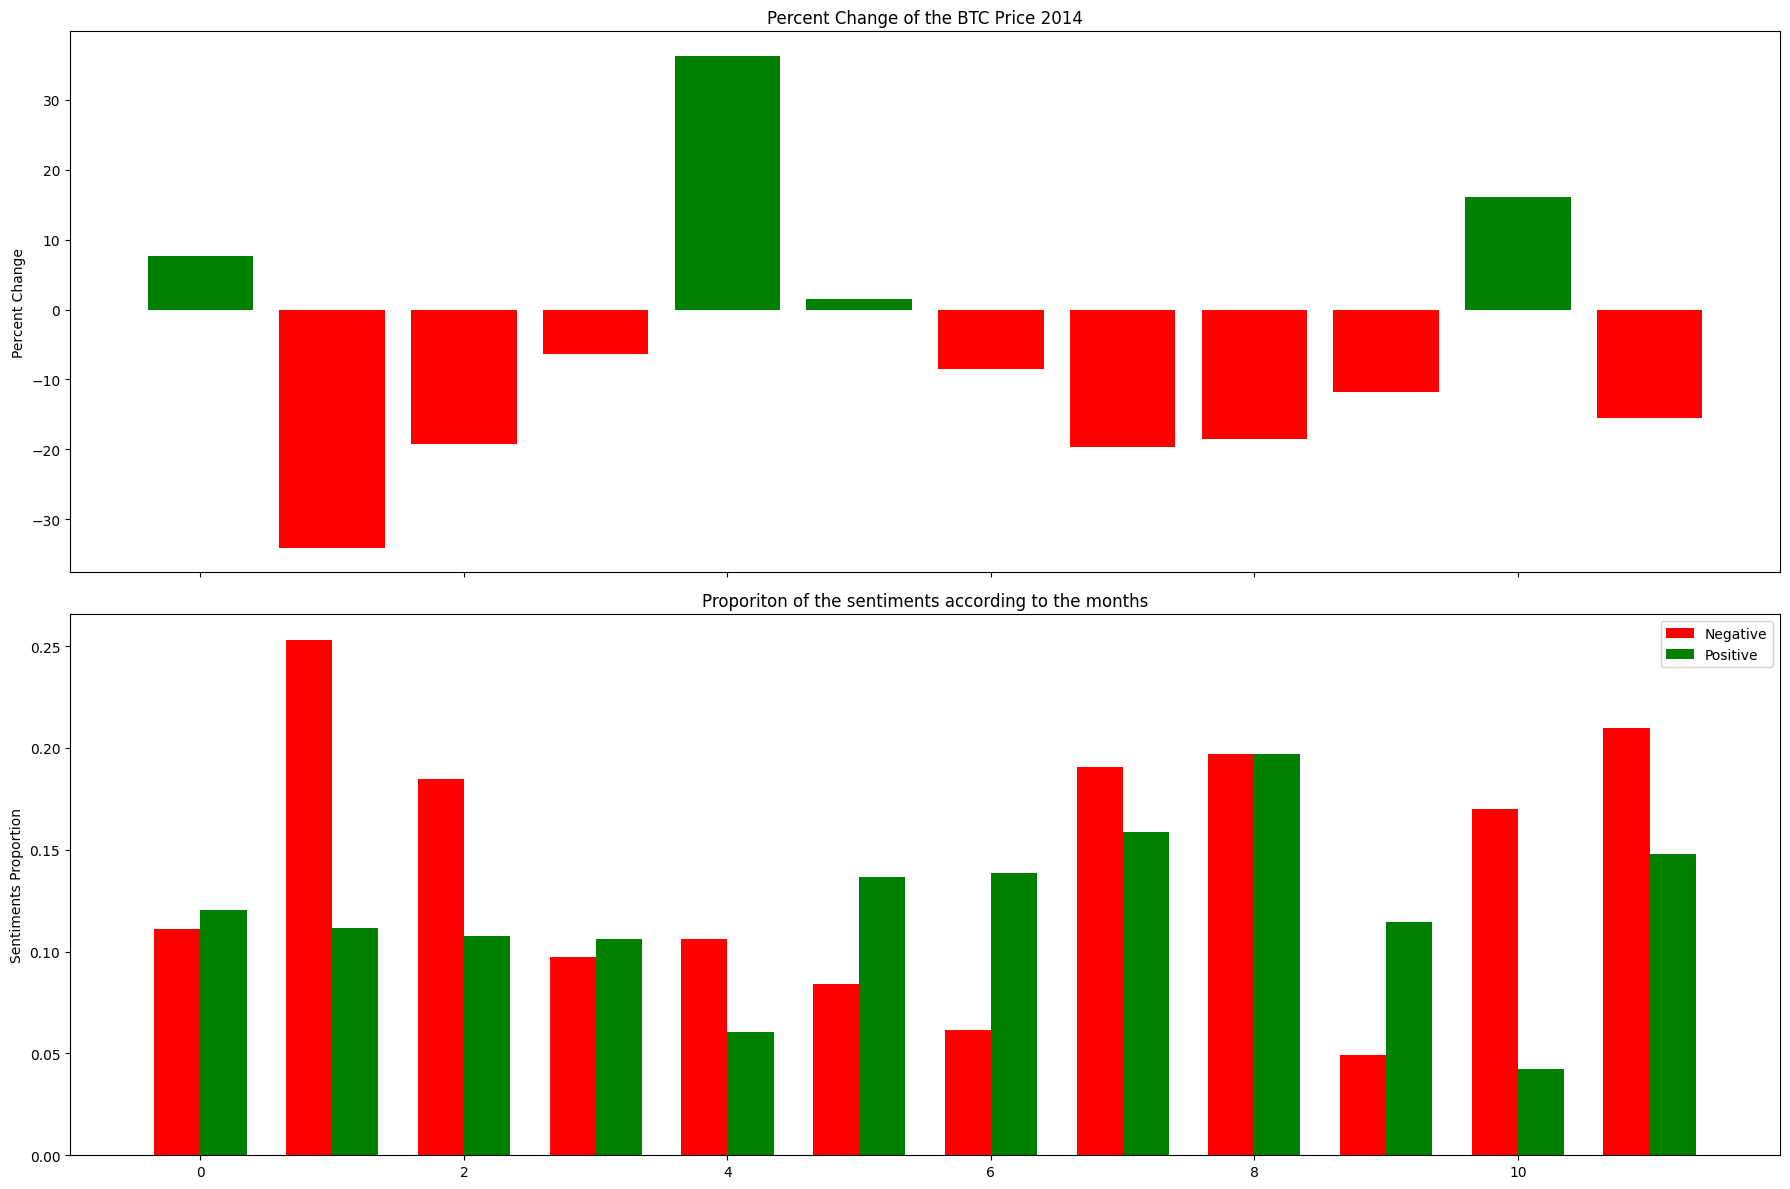

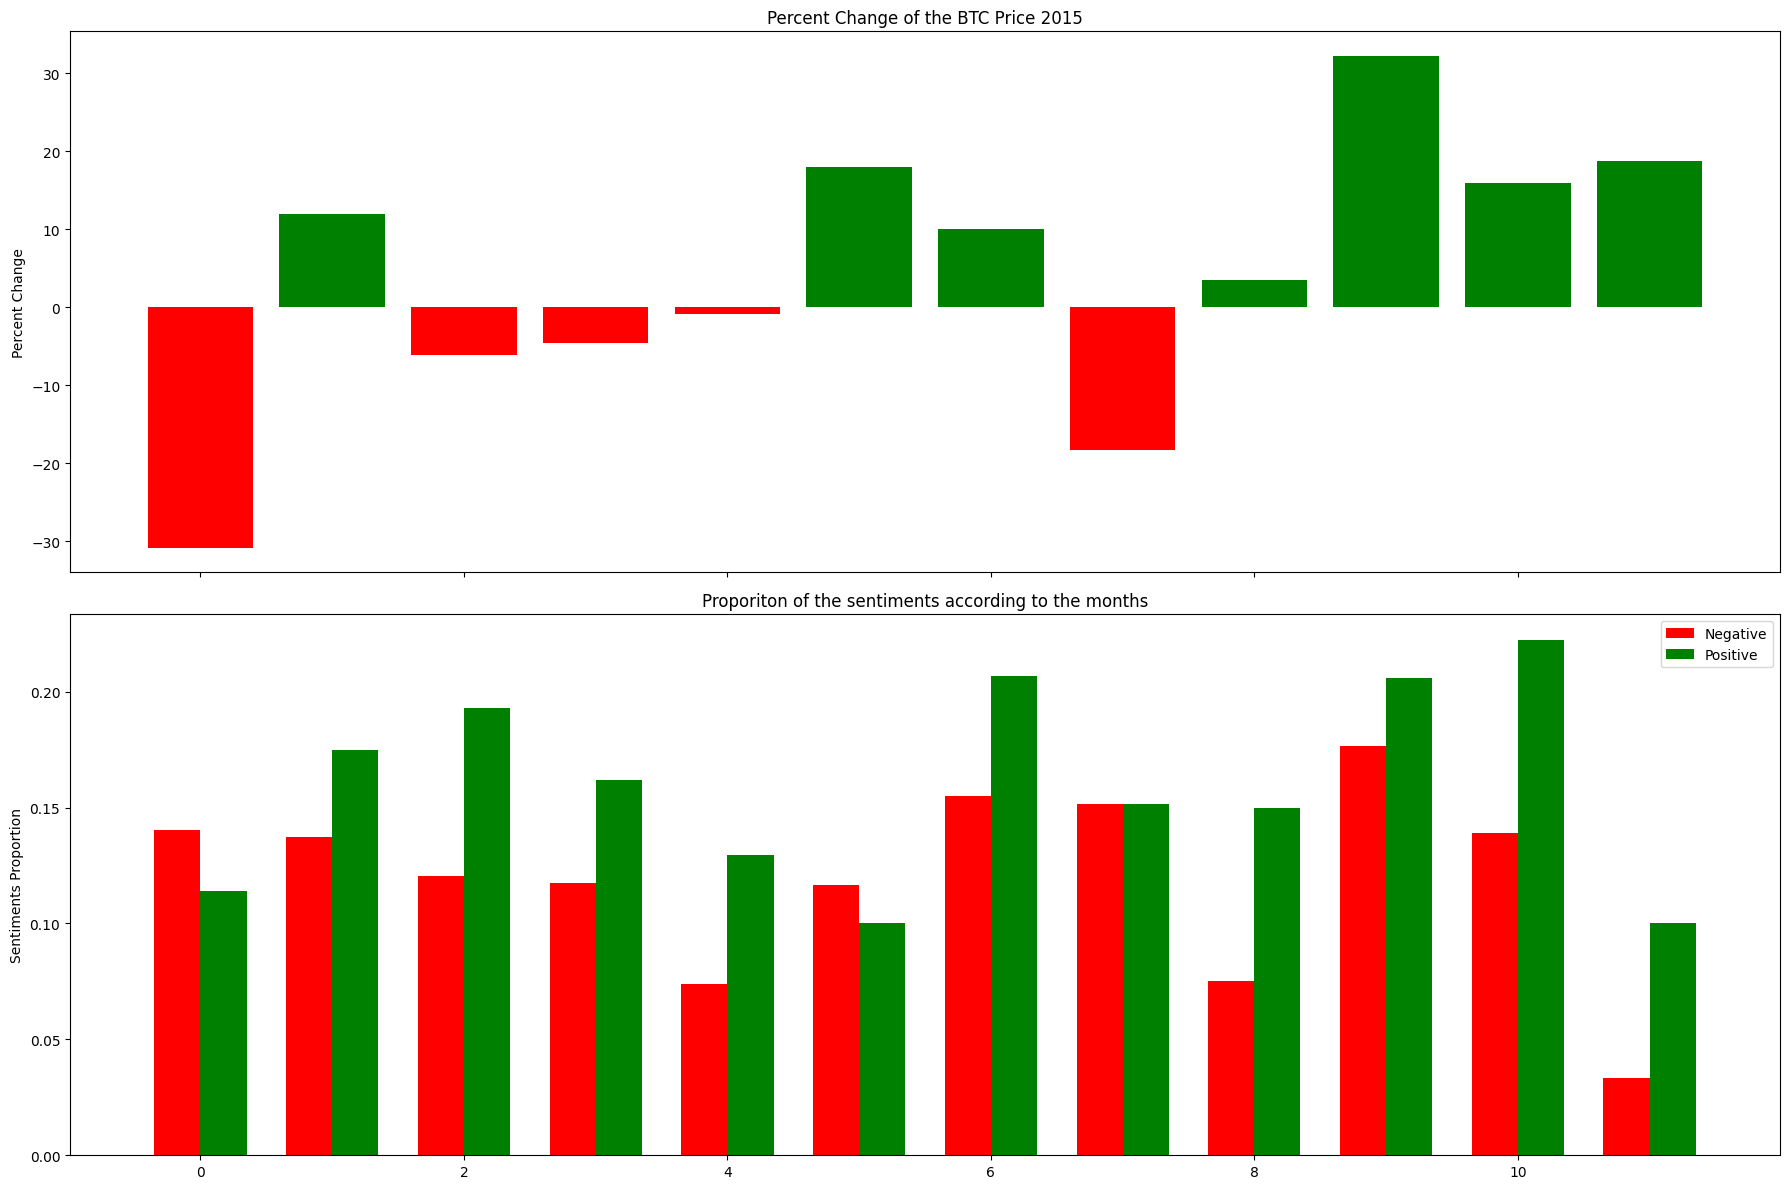

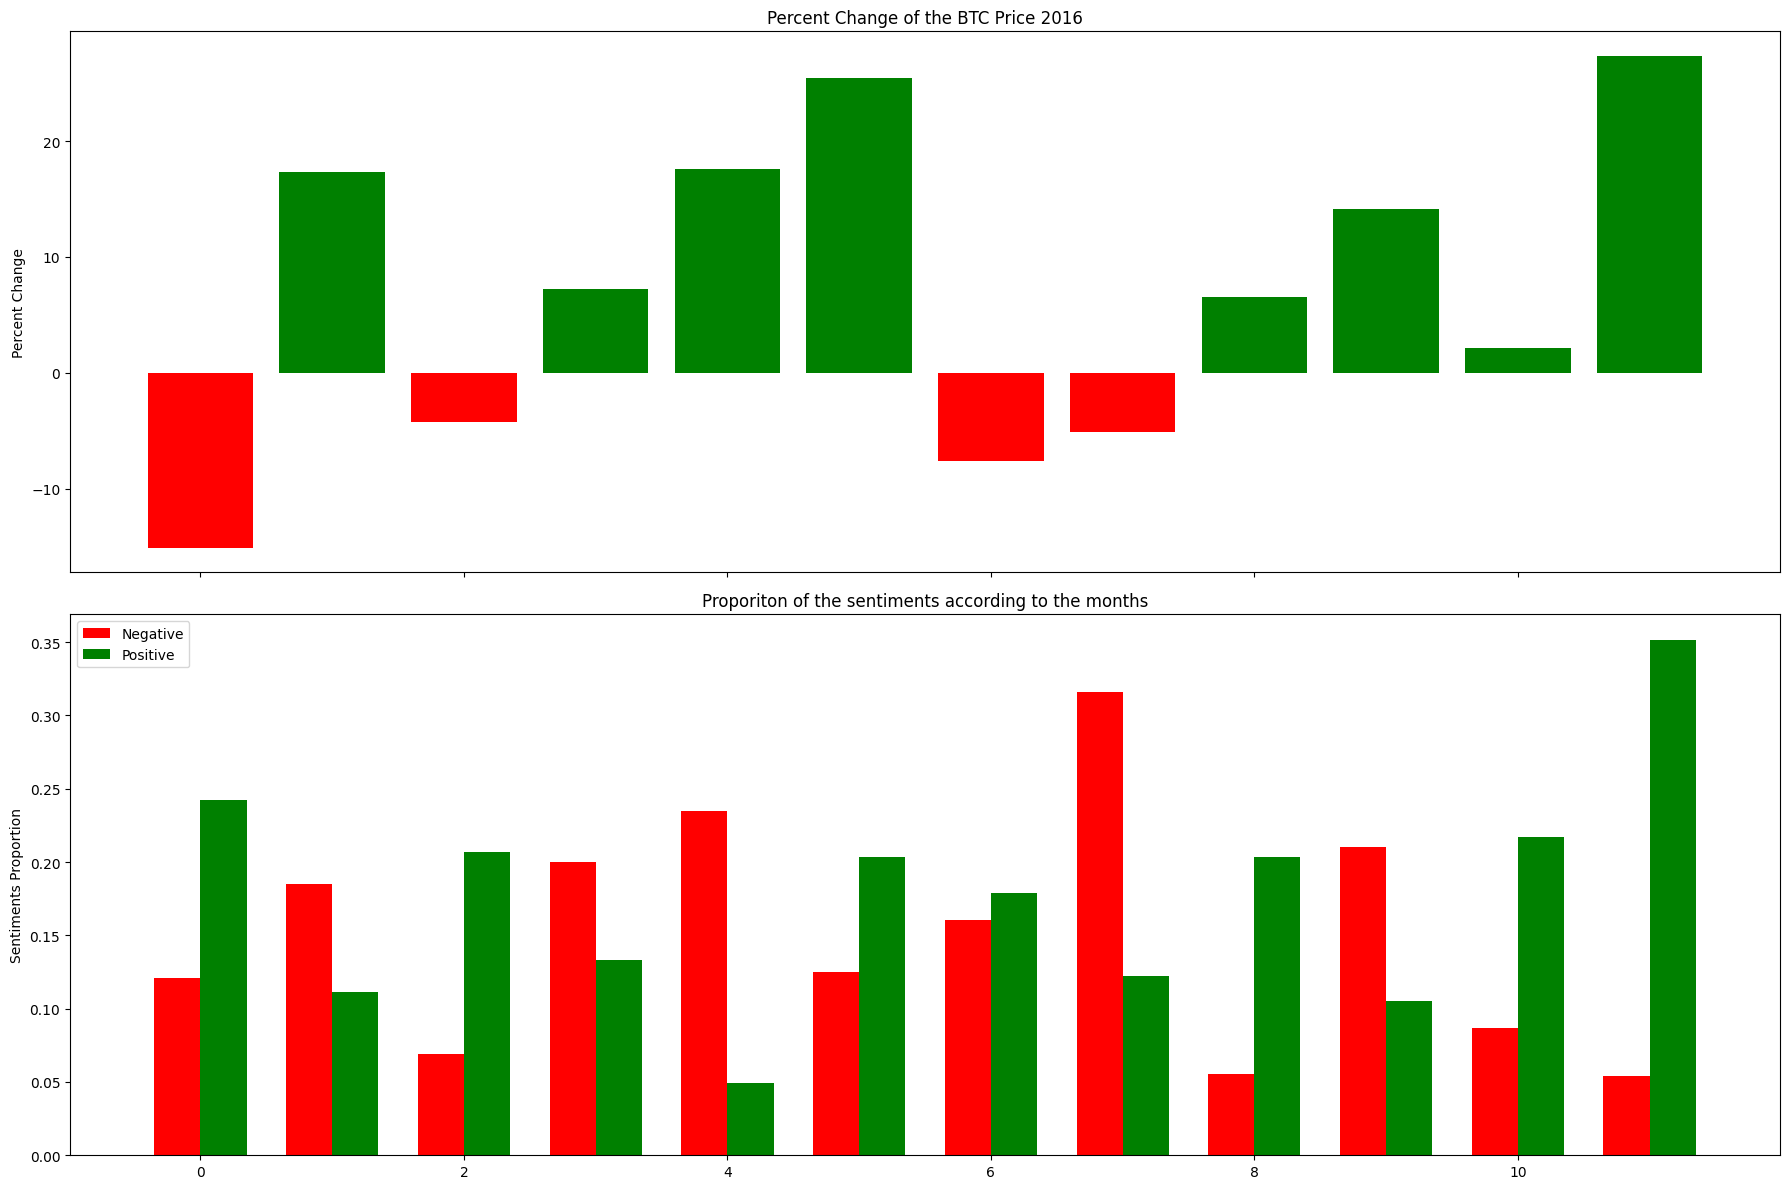

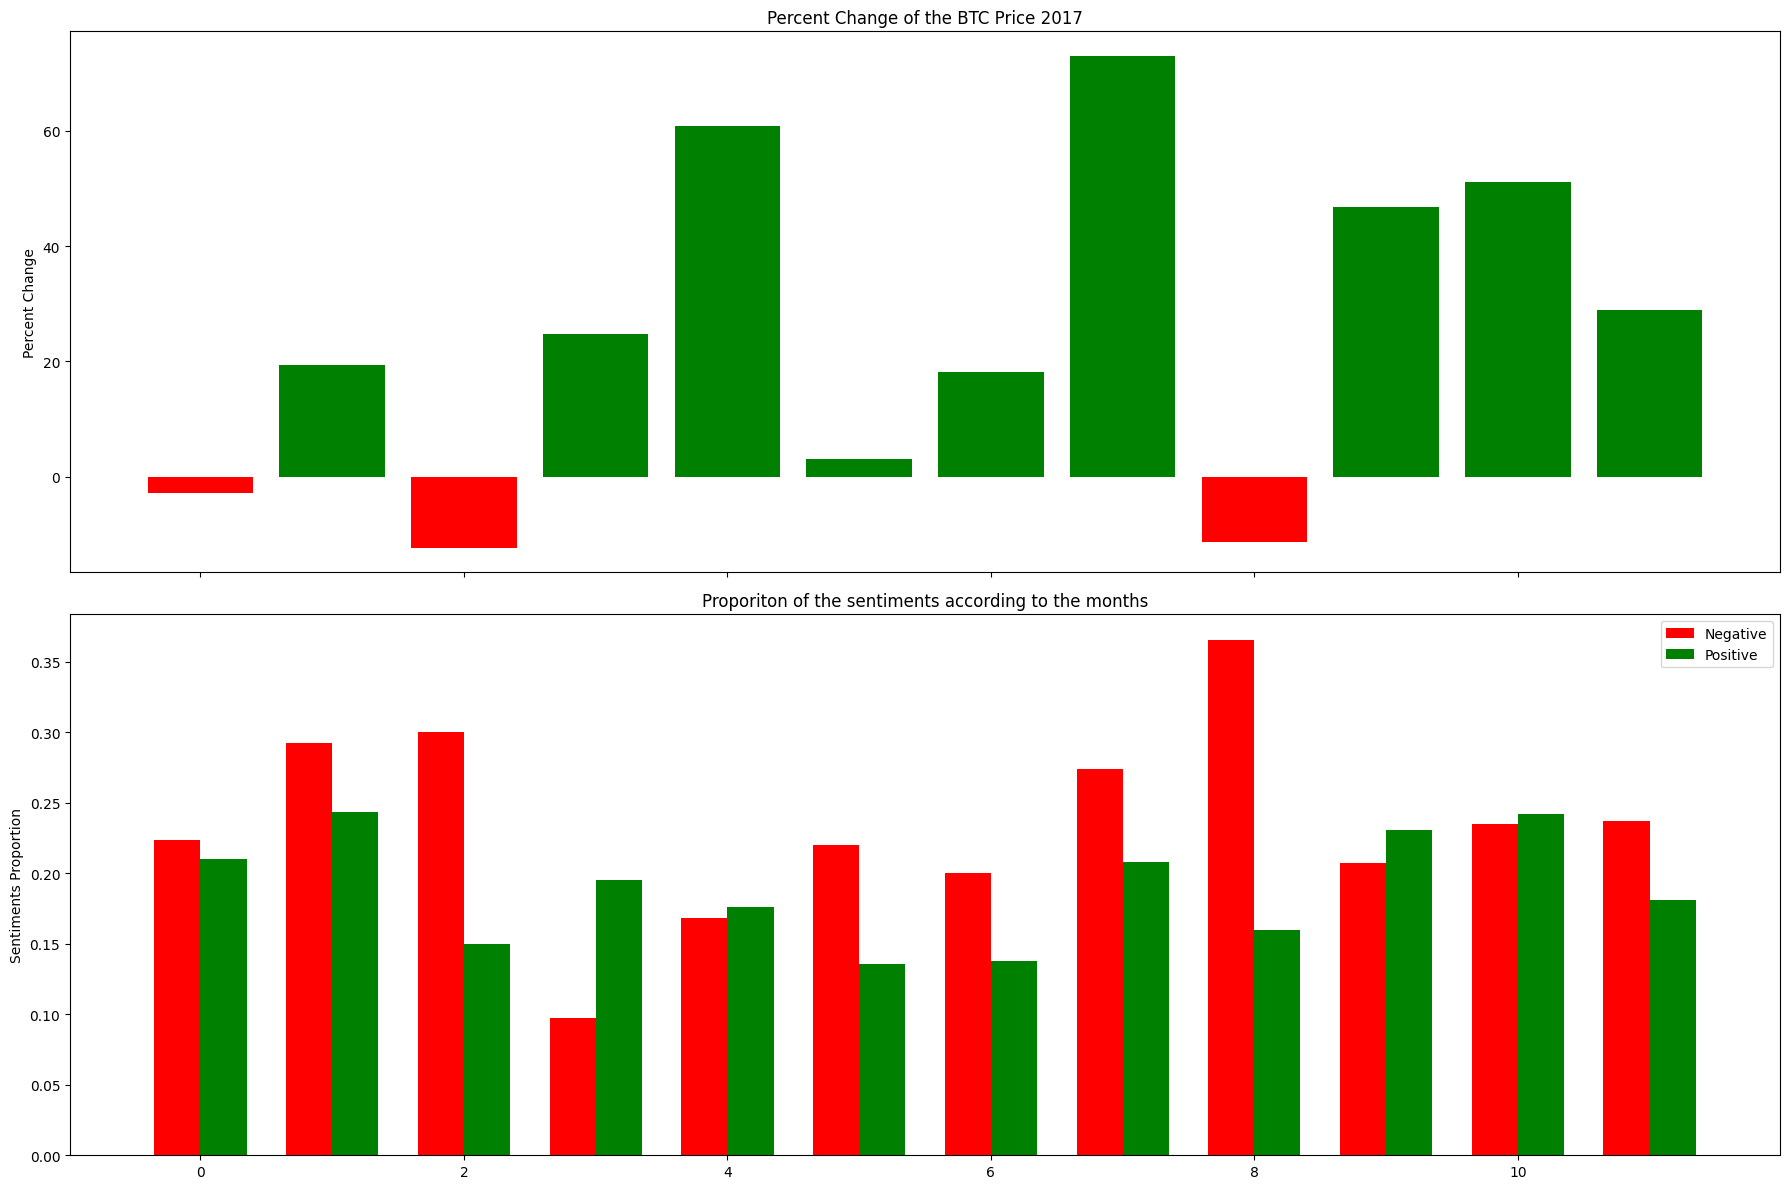

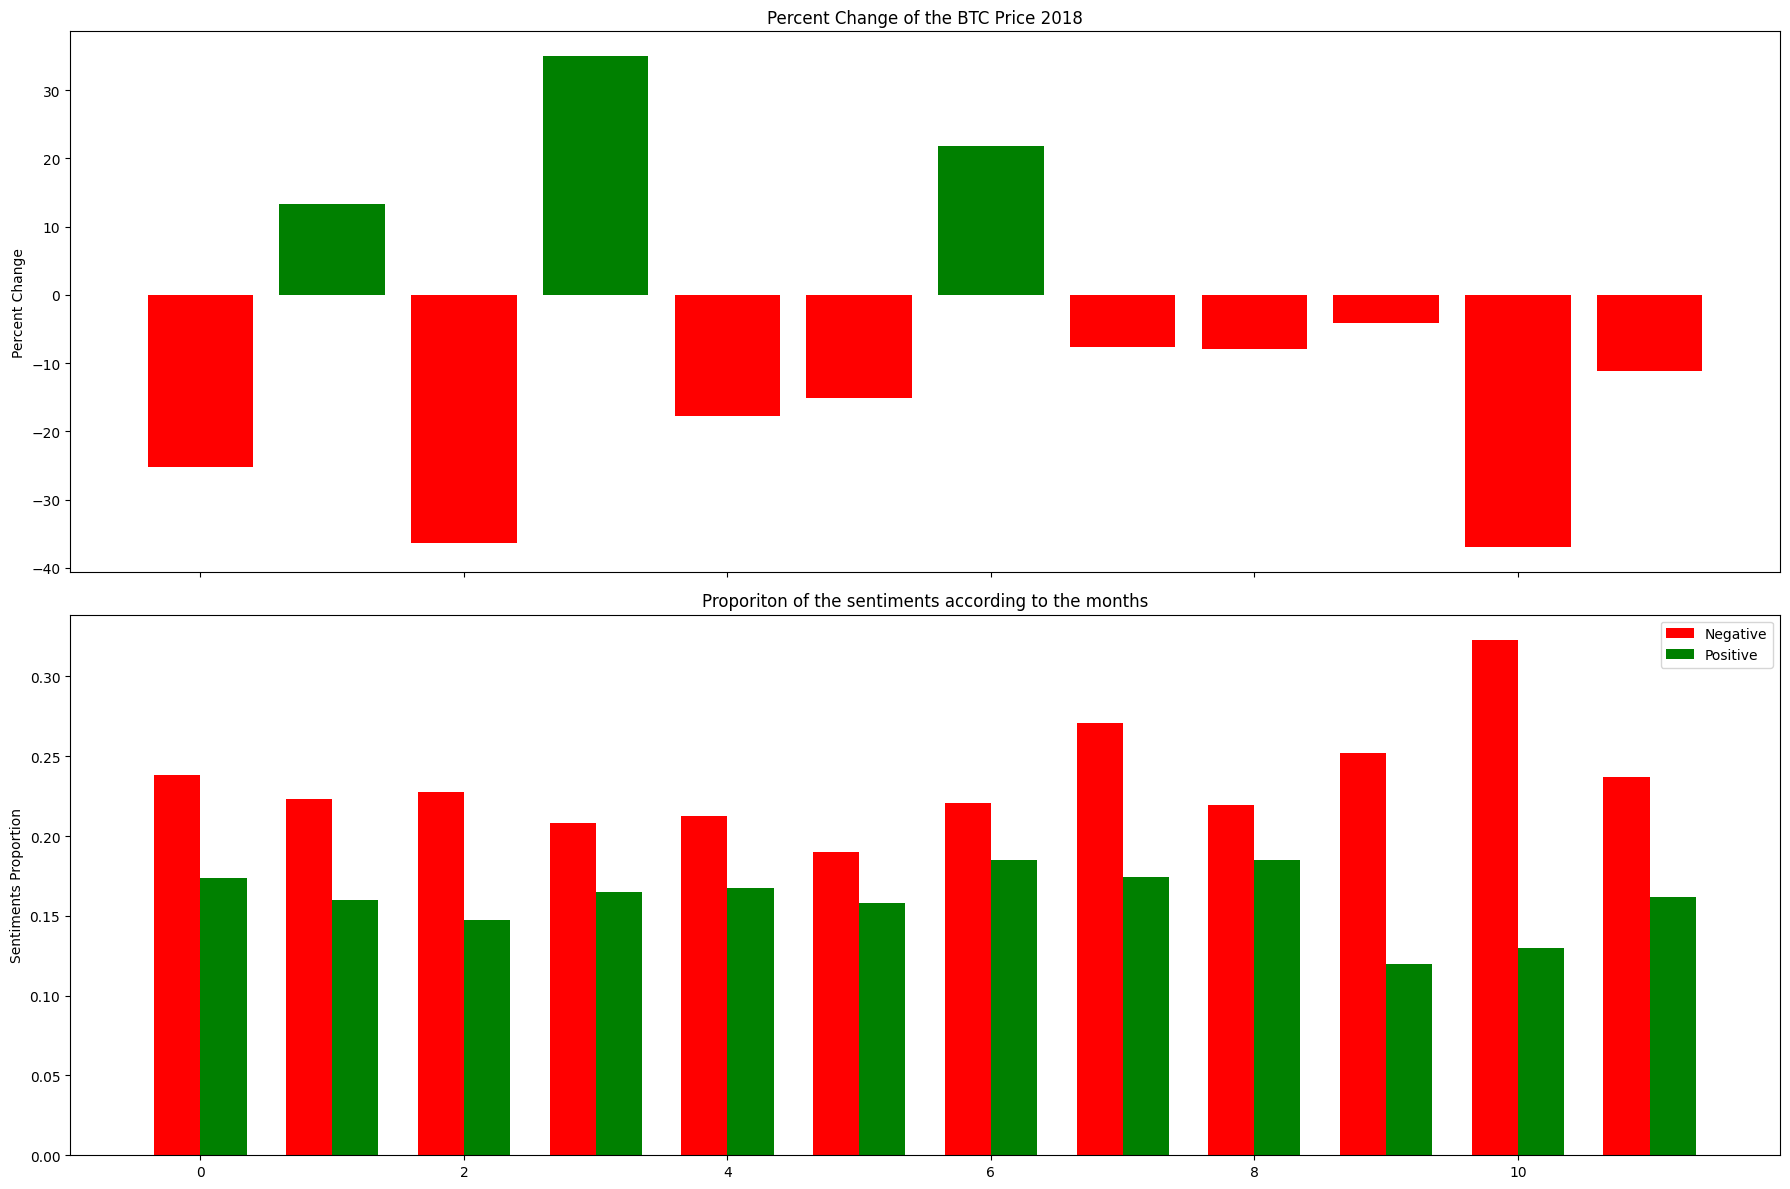

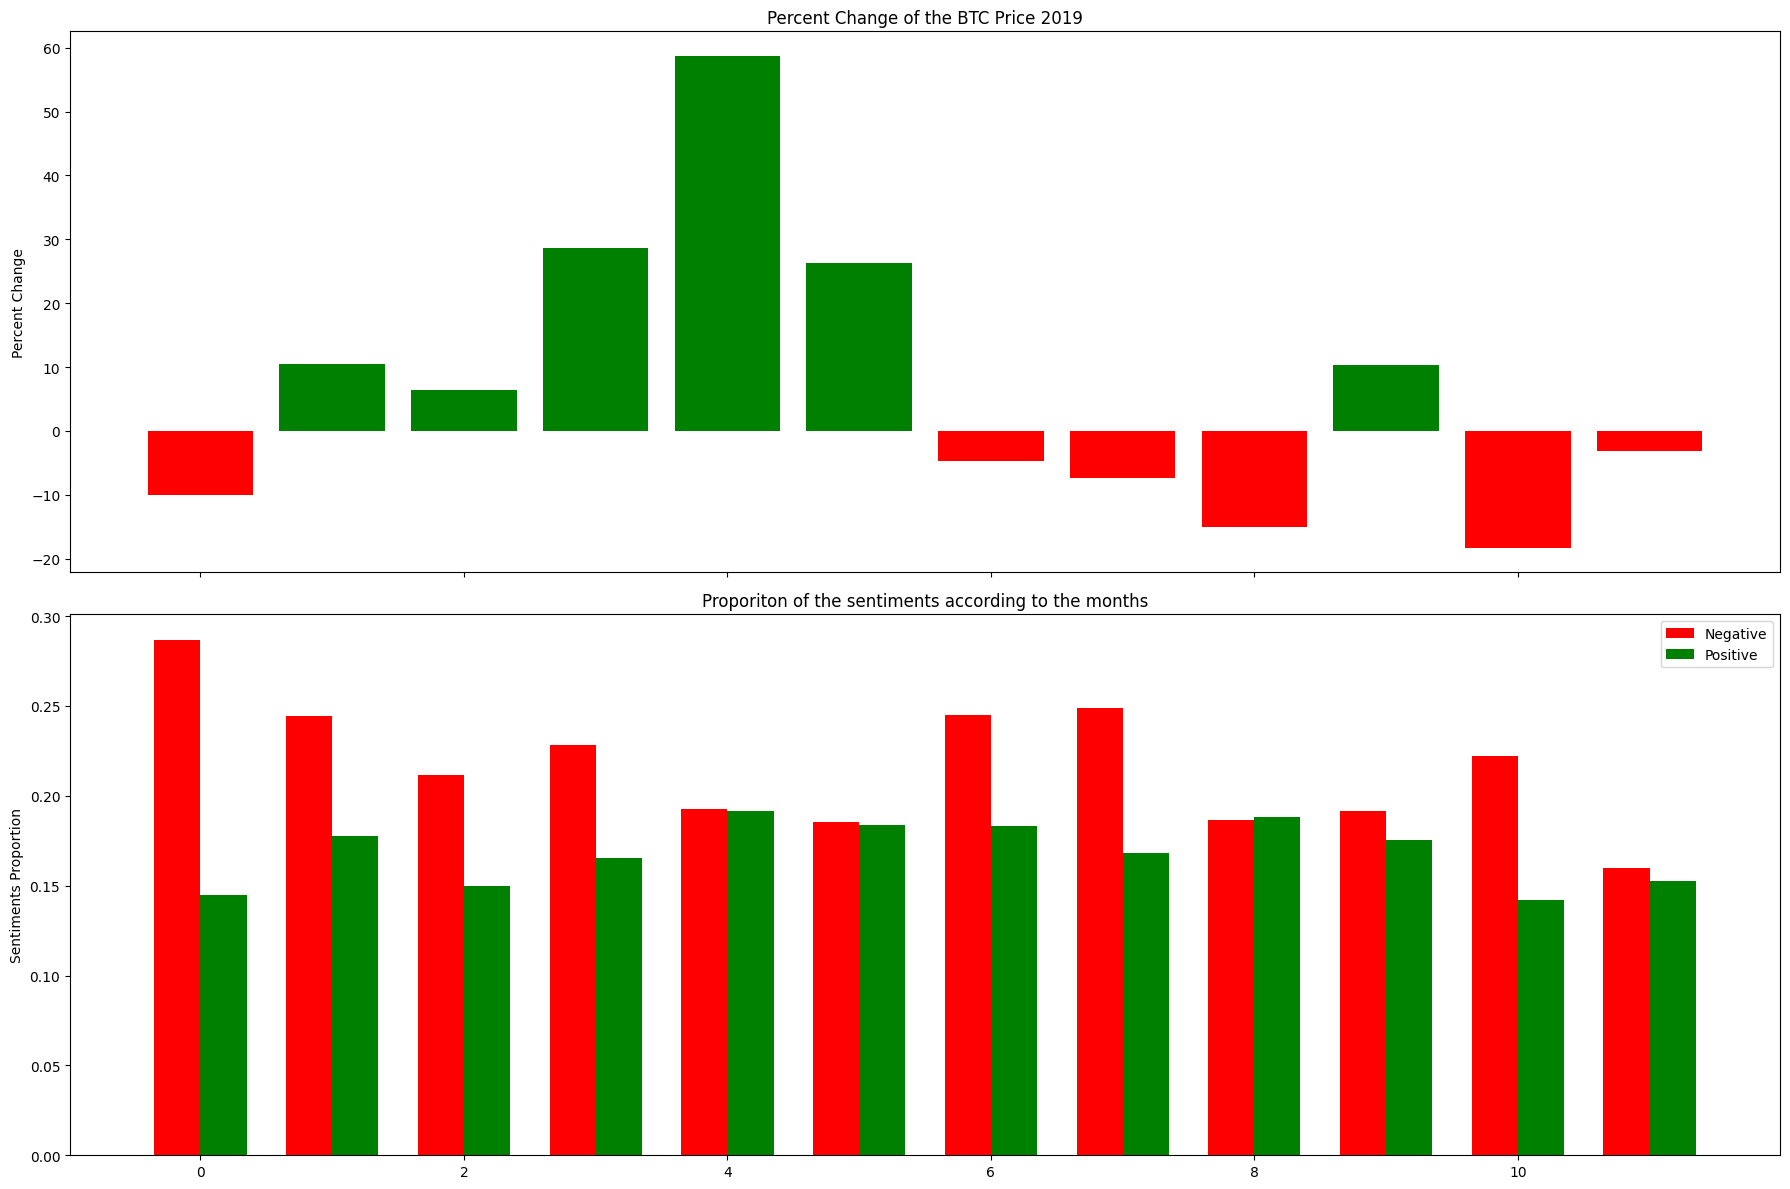

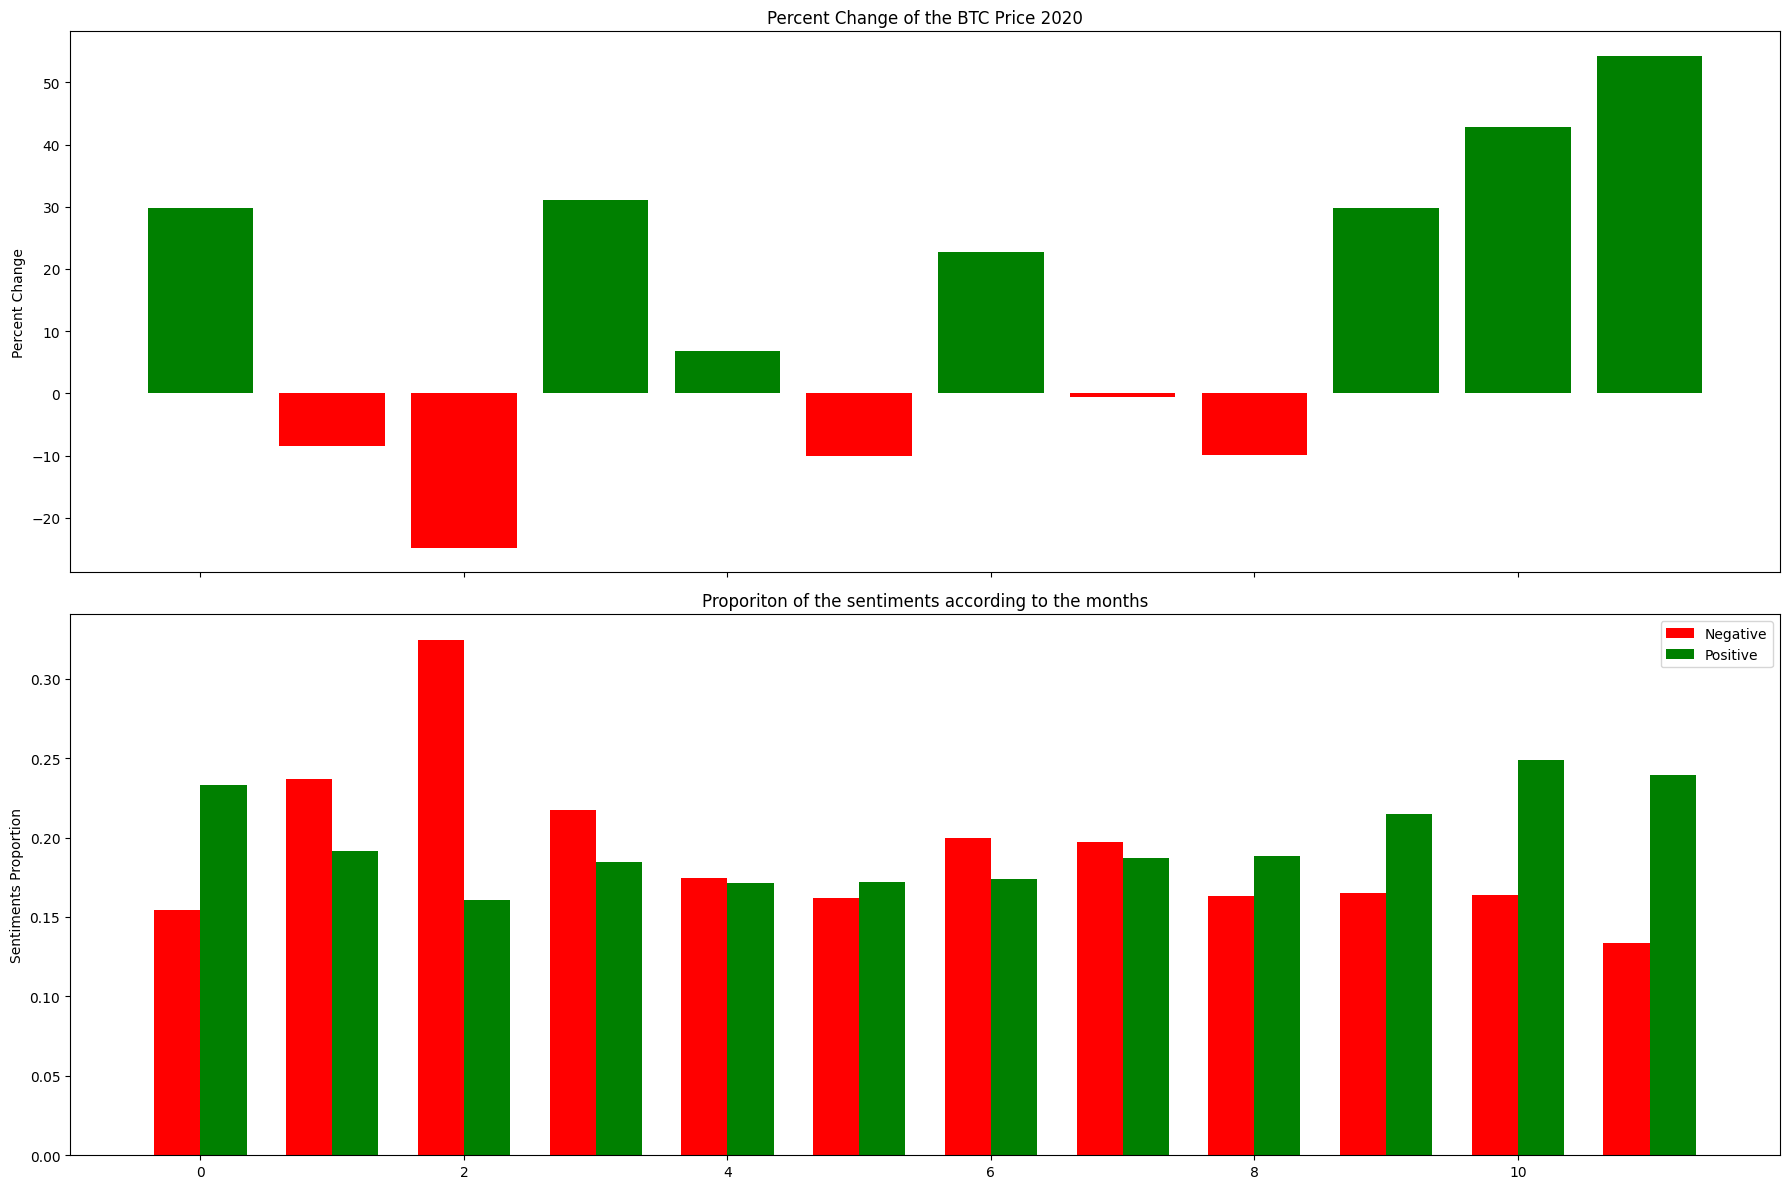

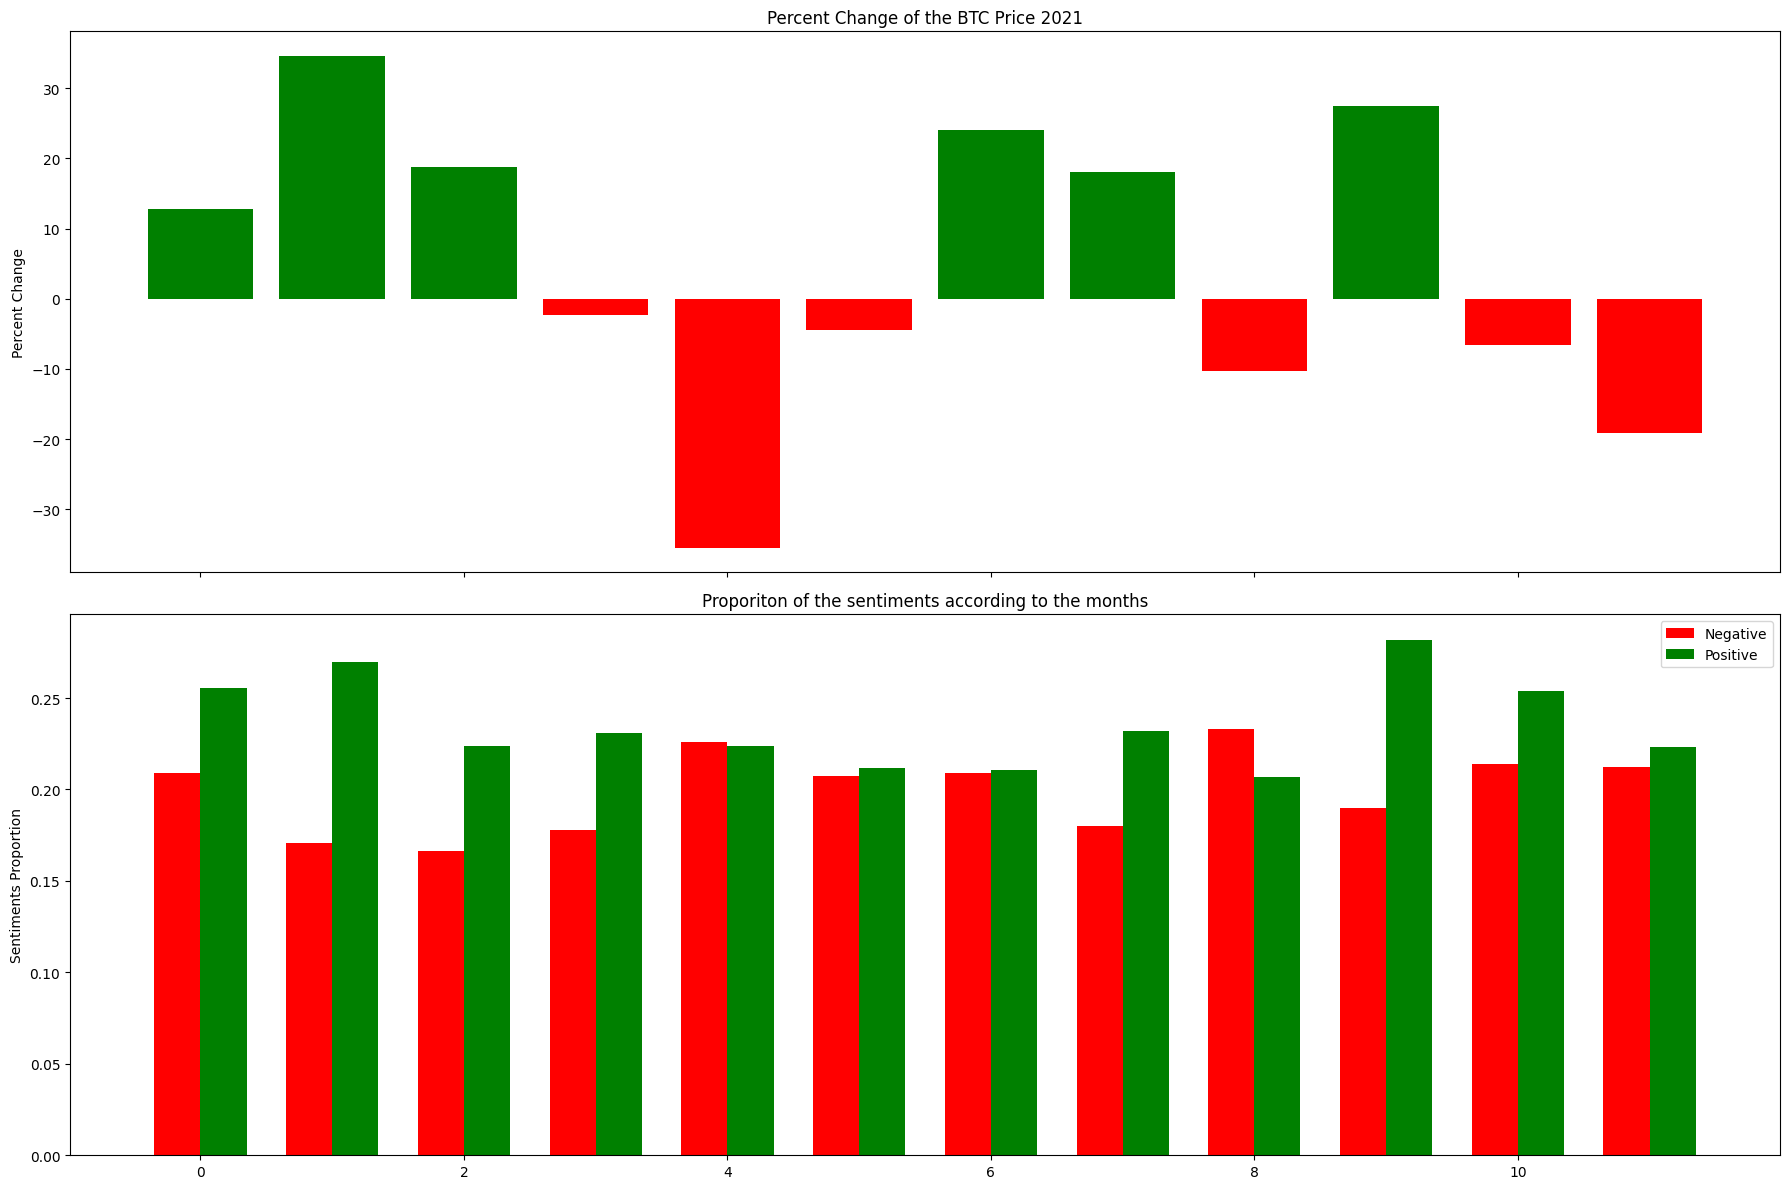

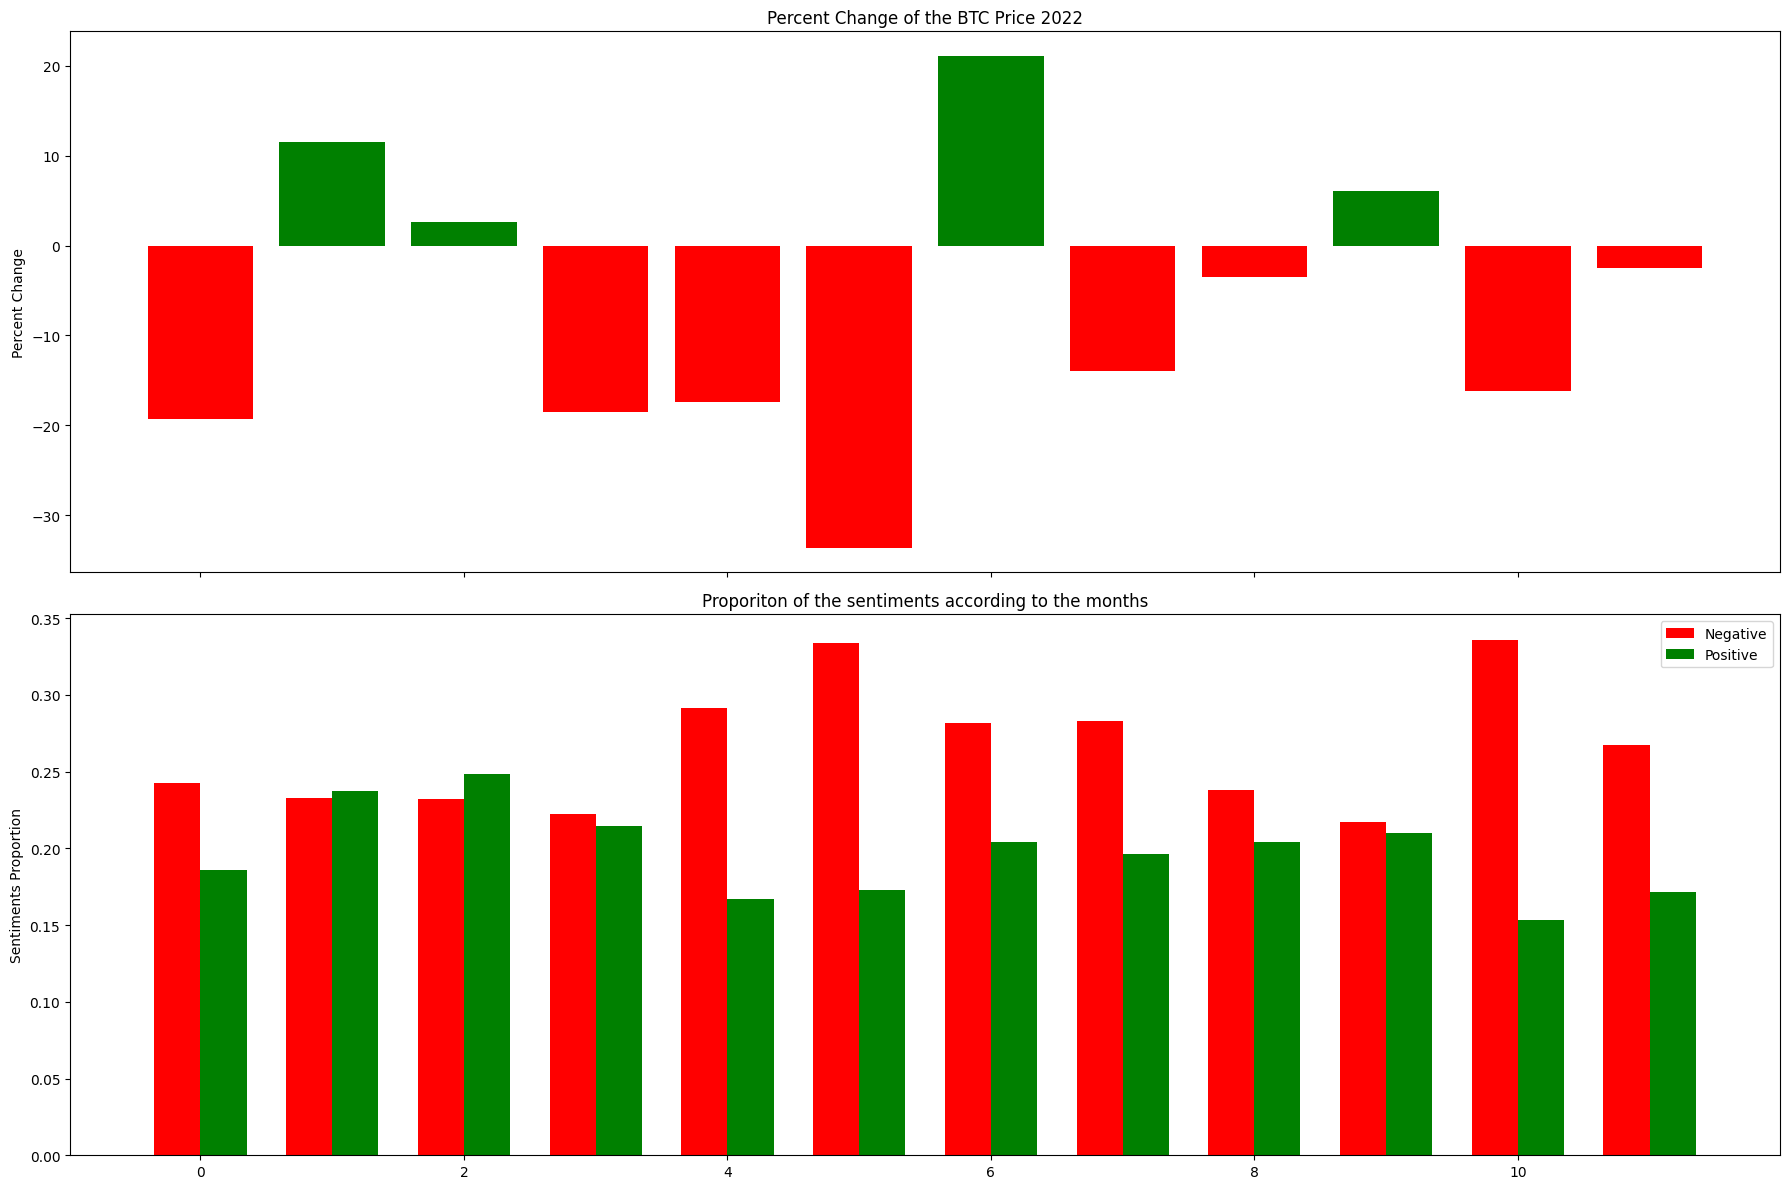

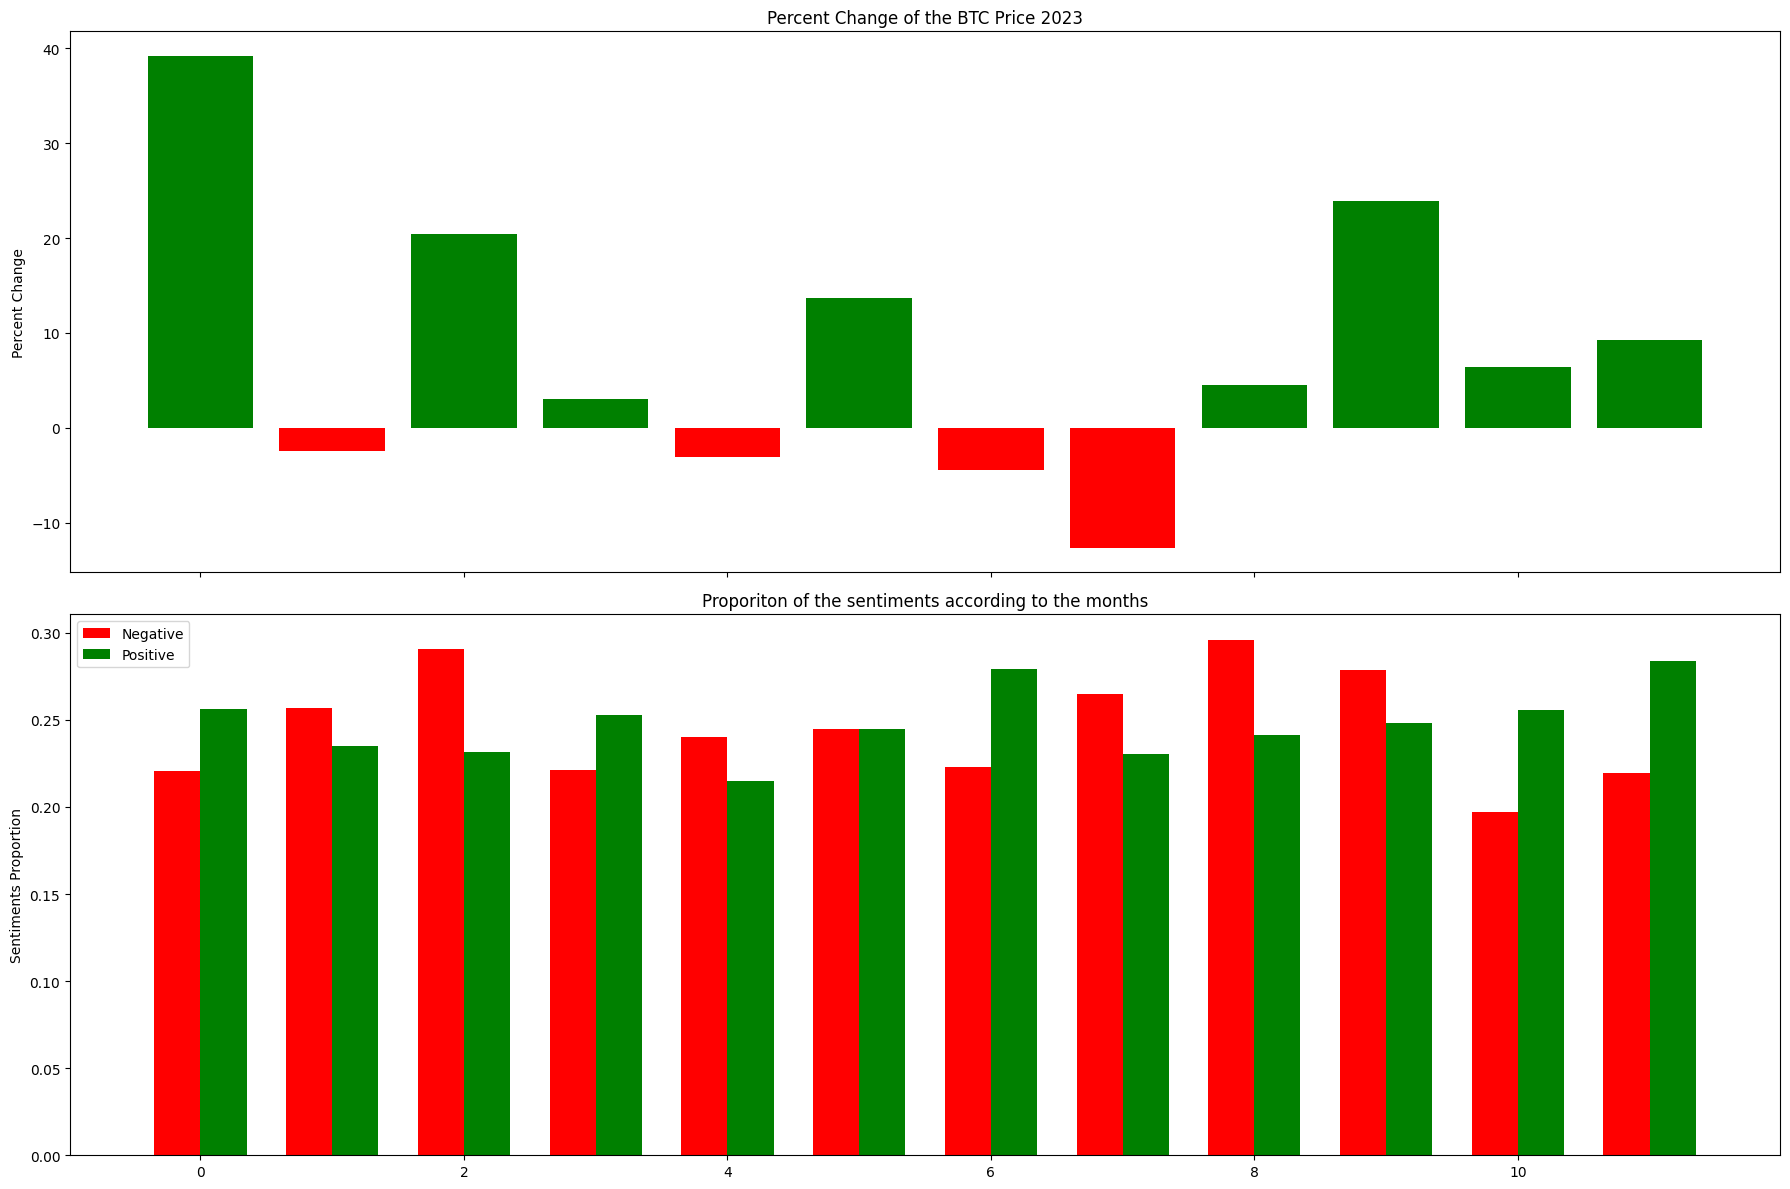

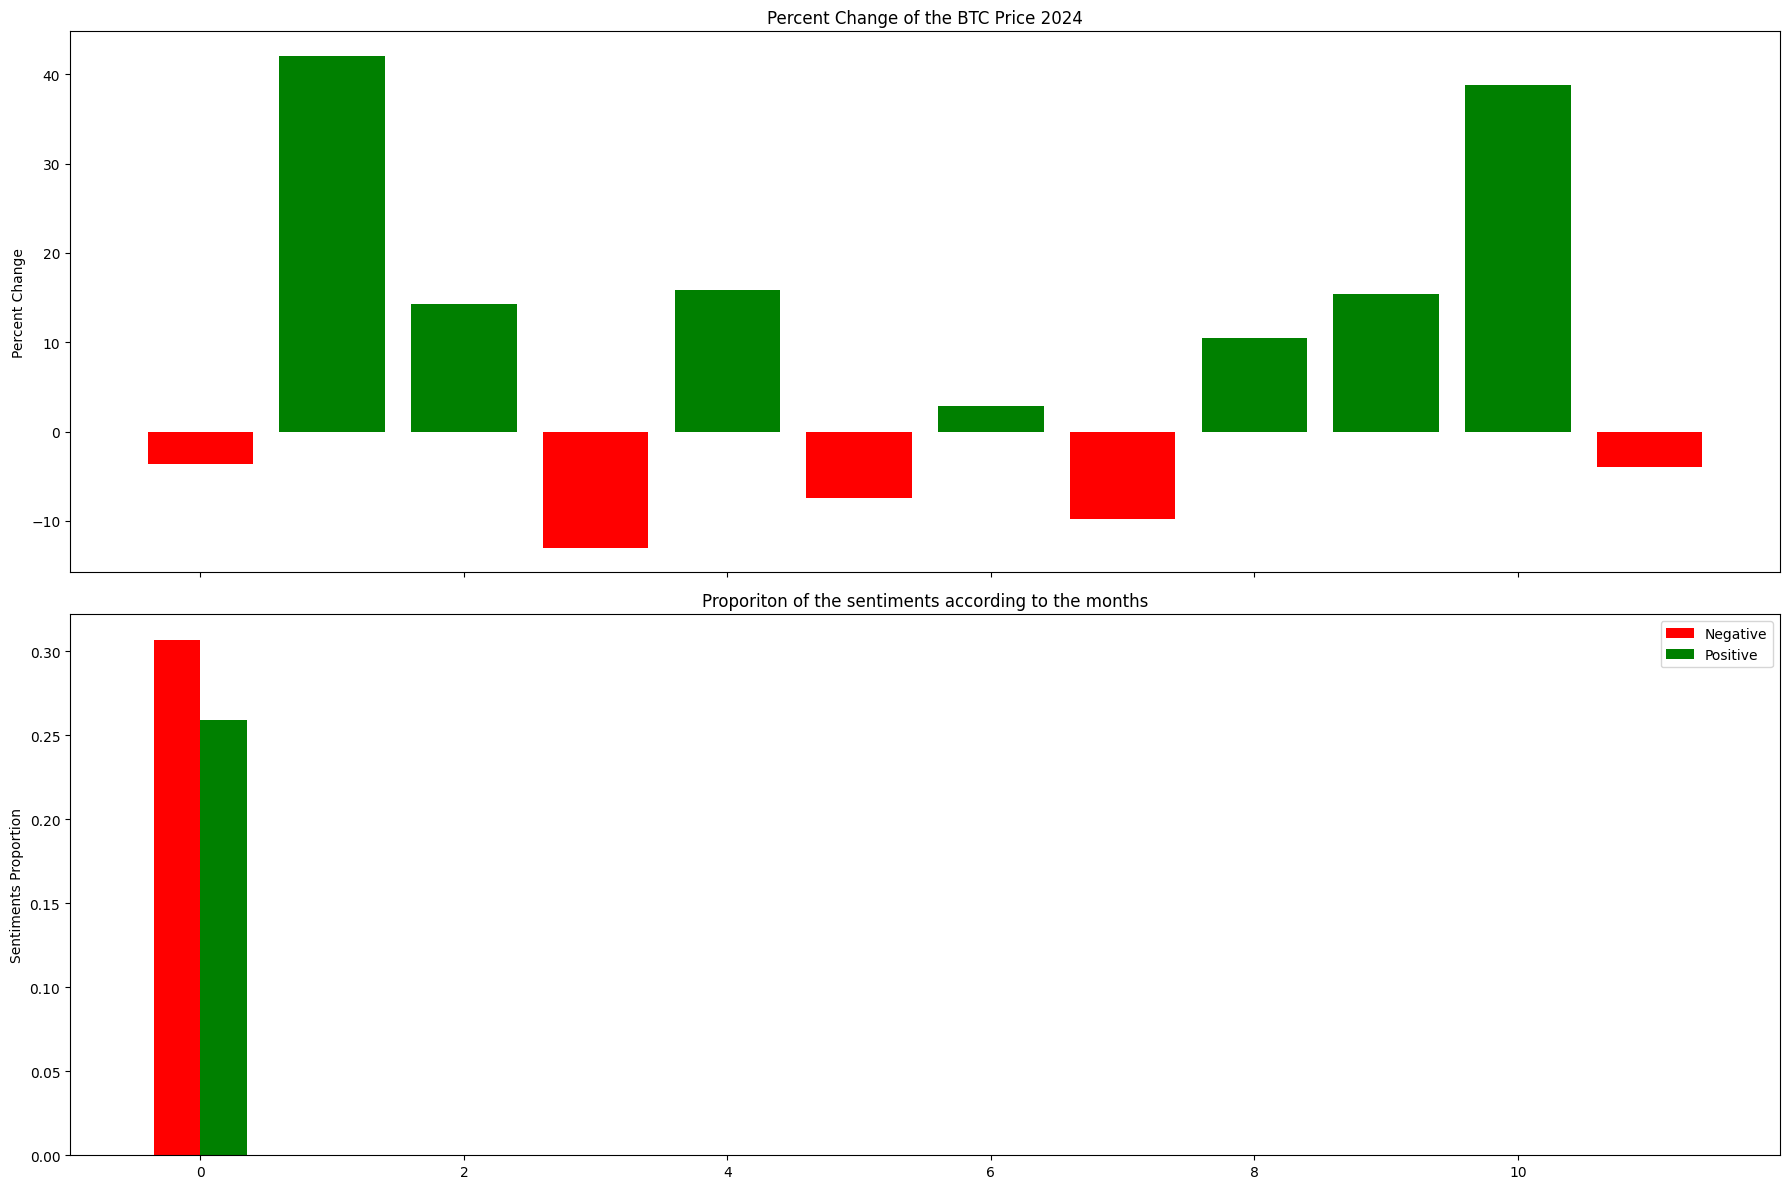

In [50]:
import numpy as np

for year in years:
  # Taking sample of btc prices according to the year
  monthly_change_sample = monthly_change[monthly_change["year"] == year]
  months = monthly_change_sample["month"].tolist()
  x = np.arange(len(months))

  # Pivotting table with proportion of sentiments
  pivot = group_by_year[group_by_year['year'] == year].pivot_table(
      index='month',
      columns='finbert_sentiment',
      values='proportion',
      fill_value = 0)

  # Ensure all three sentiment columns exist
  for sentiment in ['negative', 'neutral', 'positive']:
      if sentiment not in pivot.columns:
          pivot[sentiment] = 0

  pivot = pivot.reindex(index=range(1, 13), fill_value=0)
  pivot = pivot[['negative', 'neutral', 'positive']]


  negative_vals = pivot['negative'].tolist()
  neutral_vals = pivot['neutral'].tolist()
  positive_vals = pivot['positive'].tolist()

  # Creating 2 plots with price change and proporiton of sentiments
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 12))

  # Price change bar plot
  dynamic_color_list = ["green" if x > 0 else "red" for x in monthly_change_sample["percent_change"]]
  ax1.bar(x, monthly_change_sample["percent_change"], color=dynamic_color_list)
  ax1.set_title(f"Percent Change of the BTC Price {year}")
  ax1.set_ylabel("Percent Change")

  # Sentiment bar plots
  bar_width = 0.35
  ax2.bar(x - bar_width/2, negative_vals, width=bar_width, label='Negative', color='red')
  ax2.bar(x + bar_width/2, positive_vals, width=bar_width, label='Positive', color='green')
  ax2.set_ylabel("Sentiments Proportion")
  ax2.set_title("Proporiton of the sentiments according to the months")
  ax2.legend()

  plt.tight_layout()
  plt.show()

## Predictive Analysis

###Preparation of the dataset. Version 1

In [1]:
import pandas as pd

btc = pd.read_csv("/content/bitcoin_articles_with_finbert_sentiment.csv")
btc.head()

,title,source,date,finbert_sentiment,finbert_score
0,Compromised account leads to massive Bitcoin s...,Engadget,2011-06-22,negative,0.801531
1,Bitcoin May Be The Currency Of The Future,Investopedia,2012-02-01,neutral,0.899791
2,Should Africa Adopt a Shared Currency? And Sho...,The Atlantic,2012-03-22,neutral,0.919918
3,"MasterCard denies BitCoin card rumors, BitInst...",Engadget,2012-08-22,neutral,0.906358
4,Claim of Romney taxes theft a puzzling whodunit,Associated Press,2012-09-07,neutral,0.567120


In [2]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80806 entries, 0 to 80805
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              80806 non-null  object 
 1   source             80806 non-null  object 
 2   date               80806 non-null  object 
 3   finbert_sentiment  80806 non-null  object 
 4   finbert_score      80806 non-null  float64
dtypes: float64(1), object(4)
memory usage: 3.1+ MB


In [3]:
summary_df = btc.groupby(['date', 'finbert_sentiment']).size().unstack(fill_value=0).reset_index()
sentiment_part = summary_df[["date", "negative", "neutral", "positive"]]
sentiment_part.head()

finbert_sentiment,date,negative,neutral,positive
0,2011-06-22,1,0,0
1,2012-02-01,0,1,0
2,2012-03-22,0,1,0
3,2012-08-22,0,1,0
4,2012-09-07,0,2,0


In [7]:
sentiment_part["date"] = pd.to_datetime(sentiment_part["date"])

In [4]:
price_part = pd.read_csv("BTC.csv")
price_part.head()

,date,ticker,open,high,low,close,volume
0,2010-07-14,BTC,0.058157,0.061588,0.048647,0.056402,261.54
1,2010-07-15,BTC,0.056403,0.067954,0.053969,0.057568,445.80
2,2010-07-16,BTC,0.058001,0.072220,0.057484,0.066492,497.25
3,2010-07-17,BTC,0.066500,0.077735,0.057418,0.065993,19.99
4,2010-07-18,BTC,0.066088,0.080858,0.064221,0.078814,75.13


In [5]:
price_part["date"] = pd.to_datetime(price_part["date"])

In [8]:
merged_df = pd.merge(sentiment_part,price_part, on="date")
merged_df

,date,negative,neutral,positive,ticker,open,high,low,close,volume
0,2011-06-22,1,0,0,BTC,17.067233,17.880056,14.186919,15.581525,0.000000e+00
1,2012-02-01,0,1,0,BTC,5.561340,6.150094,5.165570,5.756635,1.151335e+05
2,2012-03-22,0,1,0,BTC,4.877525,5.354590,4.058745,4.861628,5.821575e+04
3,2012-08-22,0,1,0,BTC,10.425985,10.502741,8.515705,10.276300,6.762247e+04
4,2012-09-07,0,2,0,BTC,10.949685,13.363874,10.719959,11.144520,3.550719e+04
...,...,...,...,...,...,...,...,...,...,...
3413,2024-01-20,6,12,7,BTC,41624.589029,41877.893918,41446.823090,41665.584836,1.158669e+10
3414,2024-01-21,8,9,5,BTC,41671.488525,41855.368721,41497.009664,41545.783514,9.344044e+09
3415,2024-01-22,54,39,30,BTC,41553.652691,41651.206793,39450.118993,39507.368824,3.133871e+10
3416,2024-01-23,36,30,19,BTC,39518.715453,40127.353427,38521.893888,39845.551147,2.924455e+10


In [9]:
columns_to_drop = ["ticker"]
merged_df.drop(columns=columns_to_drop, inplace=True)
merged_df

,date,negative,neutral,positive,open,high,low,close,volume
0,2011-06-22,1,0,0,17.067233,17.880056,14.186919,15.581525,0.000000e+00
1,2012-02-01,0,1,0,5.561340,6.150094,5.165570,5.756635,1.151335e+05
2,2012-03-22,0,1,0,4.877525,5.354590,4.058745,4.861628,5.821575e+04
3,2012-08-22,0,1,0,10.425985,10.502741,8.515705,10.276300,6.762247e+04
4,2012-09-07,0,2,0,10.949685,13.363874,10.719959,11.144520,3.550719e+04
...,...,...,...,...,...,...,...,...,...
3413,2024-01-20,6,12,7,41624.589029,41877.893918,41446.823090,41665.584836,1.158669e+10
3414,2024-01-21,8,9,5,41671.488525,41855.368721,41497.009664,41545.783514,9.344044e+09
3415,2024-01-22,54,39,30,41553.652691,41651.206793,39450.118993,39507.368824,3.133871e+10
3416,2024-01-23,36,30,19,39518.715453,40127.353427,38521.893888,39845.551147,2.924455e+10


Finding longest consuequent number of days with sentiment data

In [10]:
# Sorting values by date
merged_df = merged_df.sort_values(by = "date").reset_index(drop=True)

# Finding gap days between dates
merged_df['gap_days'] = merged_df['date'].diff().dt.days

# Labeling consecutive segments
merged_df['segment_id'] = (merged_df['gap_days'] != 1).cumsum()

# Finding segments with most rows
segment_sizes = merged_df.groupby('segment_id').size()
longest_segment_id = segment_sizes.idxmax()

# Get that entire consecutive segment
longest_segment_df = merged_df[merged_df['segment_id'] == longest_segment_id].copy()

# Drop gap_days and segment_id
longest_segment_df.drop(['gap_days', 'segment_id'], axis=1, inplace=True)

longest_segment_df

,date,negative,neutral,positive,open,high,low,close,volume
1155,2017-11-12,4,1,2,6295.450195,6625.049805,5519.009766,5950.069824,8.957350e+09
1156,2017-11-13,13,20,12,5938.250000,6811.189941,5844.290039,6559.490234,6.263250e+09
1157,2017-11-14,0,5,3,6561.479980,6764.979980,6461.750000,6635.750000,3.197110e+09
1158,2017-11-15,6,17,5,6634.759766,7342.250000,6634.759766,7315.540039,4.200880e+09
1159,2017-11-16,5,14,4,7323.240234,7967.379883,7176.580078,7871.689941,5.123810e+09
...,...,...,...,...,...,...,...,...,...
3257,2023-08-15,6,11,3,29408.048590,29439.120422,29088.853277,29170.347206,1.264020e+10
3258,2023-08-16,7,10,5,29169.074020,29221.975743,28701.779525,28701.779525,1.494927e+10
3259,2023-08-17,8,7,5,28699.802840,28745.946525,25409.111603,26664.549993,3.112085e+10
3260,2023-08-18,19,8,2,26636.078402,26808.195785,25668.922817,26049.556901,2.402624e+10


In [11]:
longest_segment_df.to_csv("btc_sentiment_ohlcv.csv")

### Preparation Dataset. Version2

### Model creation and training

Pipeline before fitting into the model

In [12]:
# Creating target variable
longest_segment_df["close_shift"] = longest_segment_df["close"].shift(-1)
longest_segment_df["target"] = (longest_segment_df["close_shift"] > longest_segment_df["close"]).astype(int)
longest_segment_df.dropna(inplace=True)

In [13]:
# Splitting data for scaling to avoid leaking future information
train_data = longest_segment_df.iloc[:int(0.8 * len(longest_segment_df))]
test_data = longest_segment_df.iloc[int(0.8 * len(longest_segment_df)):]

Scaling model using MinMaxScaler

In [14]:
from sklearn.preprocessing import MinMaxScaler

price_columns = ['open', 'high', 'low', 'close']
volume_columns = ['volume']

price_scaler = MinMaxScaler(feature_range=(0, 1))
volume_scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting scaler on the train data
price_scaler.fit(train_data[price_columns])
volume_scaler.fit(train_data[volume_columns])

# Applying each scaler for train and test datasets
train_data[price_columns] = price_scaler.transform(train_data[price_columns])
train_data[volume_columns] = volume_scaler.transform(train_data[volume_columns])

test_data[price_columns] = price_scaler.transform(test_data[price_columns])
test_data[volume_columns] = volume_scaler.transform(test_data[volume_columns])

<ipython-input-14-a1eb7cee28b9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[price_columns] = price_scaler.transform(train_data[price_columns])
<ipython-input-14-a1eb7cee28b9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[volume_columns] = volume_scaler.transform(train_data[volume_columns])
<ipython-input-14-a1eb7cee28b9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [15]:
train_data.drop("close_shift", axis=1, inplace=True)
test_data.drop("close_shift", axis=1, inplace=True)

<ipython-input-15-0ce9c6ffe06a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop("close_shift", axis=1, inplace=True)
<ipython-input-15-0ce9c6ffe06a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop("close_shift", axis=1, inplace=True)


In [16]:
train_data

,date,negative,neutral,positive,open,high,low,close,volume,target
1155,2017-11-12,4,1,2,0.047567,0.051129,0.036836,0.042178,0.017336,1
1156,2017-11-13,13,20,12,0.042013,0.053970,0.041984,0.051651,0.009595,1
1157,2017-11-14,0,5,3,0.051703,0.053265,0.051755,0.052837,0.000786,1
1158,2017-11-15,6,17,5,0.052843,0.062076,0.054493,0.063404,0.003670,1
1159,2017-11-16,5,14,4,0.063548,0.071618,0.063067,0.072049,0.006321,0
...,...,...,...,...,...,...,...,...,...,...
2834,2022-06-18,20,7,3,0.268018,0.266517,0.229738,0.245311,0.112301,1
2835,2022-06-19,4,10,12,0.245277,0.265720,0.235412,0.269182,0.093110,1
2836,2022-06-20,21,31,12,0.269261,0.269223,0.261080,0.269901,0.080147,1
2837,2022-06-21,22,36,27,0.269897,0.280019,0.272568,0.271628,0.074837,0


In [17]:
test_data.describe()

,date,negative,neutral,positive,open,high,low,close,volume,target
count,422,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000
mean,2023-01-19 11:59:59.999999744,9.758294,19.495261,7.902844,0.312242,0.311924,0.312625,0.312389,0.061211,0.462085
min,2022-06-23 00:00:00,0.000000,0.000000,0.000000,0.195076,0.198089,0.196354,0.195096,0.009397,0.000000
25%,2022-10-06 06:00:00,3.000000,7.000000,2.000000,0.254186,0.256199,0.254328,0.254115,0.035130,0.000000
50%,2023-01-19 12:00:00,9.000000,20.000000,8.000000,0.306240,0.305602,0.306774,0.306236,0.056047,0.000000
75%,2023-05-04 18:00:00,14.000000,28.000000,12.000000,0.379042,0.379649,0.377771,0.378943,0.078375,1.000000
max,2023-08-18 00:00:00,57.000000,56.000000,32.000000,0.439075,0.435617,0.434685,0.438975,0.333489,1.000000
std,NaN,8.338069,12.196675,6.073387,0.070156,0.069801,0.070688,0.070143,0.036838,0.499152


Creating sequence with definit window size

In [18]:
import numpy as np

def create_sequences(data, feature_cols, target_col, window_size=60):
    X, y = [], []

    for i in range(len(data) - window_size):
        # Range of data for this window
        seq_x = data[feature_cols].iloc[i:i+window_size].values
        # Target is the "day after the window"
        seq_y = data[target_col].iloc[i+window_size]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

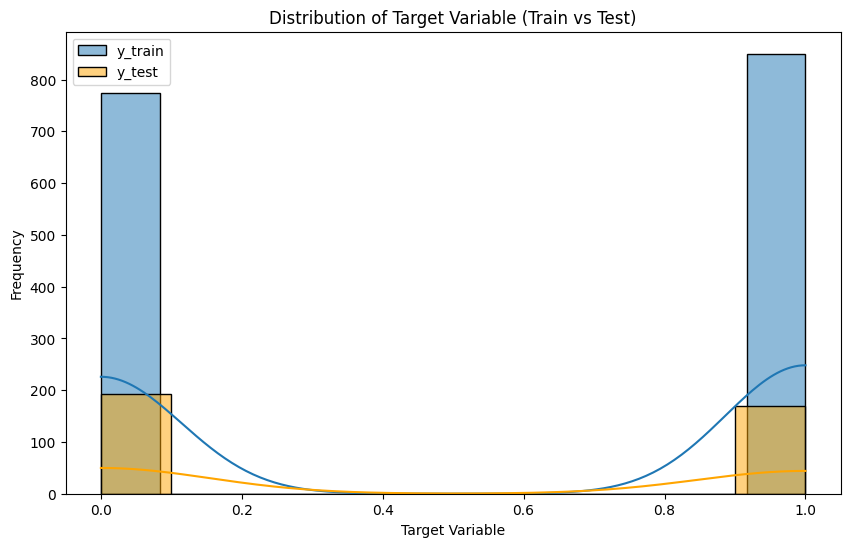

In [34]:


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train and y_test are defined from the previous code
# Example:
# y_train = ...
# y_test = ...

plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, label='y_train')
sns.histplot(y_test, kde=True, label='y_test', color='orange')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable (Train vs Test)')
plt.legend()
plt.show()


Creating model architecture

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def create_model(X_train):
  model = Sequential()

  # Model layers
  model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  Dropout(0.2)
  model.add(LSTM(units=32, return_sequences=False))
  model.add(Dense(units=64, activation="relu"))
  Dropout(0.2)
  model.add(Dense(units=32, activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  return model


Training loop for different combinations

In [60]:
window_sizes = [16, 32, 64, 128]
batch_sizes = [32, 64, 128]
results = pd.DataFrame(columns=["model", "window_size", "batch_size", "train_accuracy", "val_accuracy", "X_test", "y_test"])

for window_size in window_sizes:
  for batch_size in batch_sizes:

    # Creation of the sequences according to window size
    X_train, y_train = create_sequences(
        data=train_data,
        feature_cols=feature_cols,
        target_col=target_col,
        window_size=window_size
    )
    X_test, y_test = create_sequences(
        data=test_data,
        feature_cols=feature_cols,
        target_col=target_col,
        window_size=window_size
    )

    # Model creation with different split data
    model = create_model(X_train)

    # Training configuration with different batch sizes
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=batch_size,
        shuffle=False,
        validation_split=0.1
    )

    # Saving results
    train_acc = max(history.history["accuracy"])
    val_acc   = max(history.history["val_accuracy"])

    row_dict = {
            "model": model,
            "window_size": window_size,
            "batch_size": batch_size,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc,
            "X_test" : X_test,
            "y_test" : y_test
        }

    # Creating row dataframe
    temp_df = pd.DataFrame([row_dict])

    # Concatenate with the main results DataFrame
    results = pd.concat([results, temp_df], ignore_index=True)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5097 - loss: 0.6939 - val_accuracy: 0.5090 - val_loss: 0.6933
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5128 - loss: 0.6937 - val_accuracy: 0.5090 - val_loss: 0.6940
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5285 - loss: 0.6925 - val_accuracy: 0.5090 - val_loss: 0.6943
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5285 - loss: 0.6919 - val_accuracy: 0.5269 - val_loss: 0.6918
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5056 - loss: 0.6934 - val_accuracy: 0.5090 - val_loss: 0.6946
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5256 - loss: 0.6926 - val_accuracy: 0.5090 - val_loss: 0.6935
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5288 - loss: 0.6918 - val_accuracy: 0.5090 - val_loss: 0.6928
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5298 - loss: 0.6917 - val_accuracy: 0.5090 - val_loss: 0.6

<ipython-input-60-84d9e42e986b>:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, temp_df], ignore_index=True)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4945 - loss: 0.6960 - val_accuracy: 0.5090 - val_loss: 0.6937
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5271 - loss: 0.6924 - val_accuracy: 0.5090 - val_loss: 0.6938
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5012 - loss: 0.6928 - val_accuracy: 0.5090 - val_loss: 0.6946
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5271 - loss: 0.6921 - val_accuracy: 0.5090 - val_loss: 0.6931
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5271 - loss: 0.6918 - val_accuracy: 0.5090 - val_loss: 0.6929
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5295 - loss: 0.6916 - val_accuracy: 0.5150 - val_loss: 0.6930
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5283 - loss: 0.6917 - val_accuracy: 0.4790 - val_loss: 0.6933
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5314 - loss: 0.6910 - val_accuracy: 0.5090 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5257 - loss: 0.6937 - val_accuracy: 0.5090 - val_loss: 0.6939
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5257 - loss: 0.6922 - val_accuracy: 0.5090 - val_loss: 0.6927
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5270 - loss: 0.6918 - val_accuracy: 0.5389 - val_loss: 0.6926
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5268 - loss: 0.6912 - val_accuracy: 0.5269 - val_loss: 0.6930
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5288 - loss: 0.6911 - val_accuracy: 0.5449 - val_loss: 0.6931
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5279 - loss: 0.6925 - val_accuracy: 0.5329 - val_loss: 0.6925
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5297 - loss: 0.6911 - val_accuracy: 0.4850 - val_loss: 0.6954
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5302 - loss: 0.6918 - val_accuracy: 0.4850 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5100 - loss: 0.6954 - val_accuracy: 0.5060 - val_loss: 0.6952
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5013 - loss: 0.6945 - val_accuracy: 0.5060 - val_loss: 0.6951
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4982 - loss: 0.6938 - val_accuracy: 0.5060 - val_loss: 0.6948
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5193 - loss: 0.6935 - val_accuracy: 0.5482 - val_loss: 0.6931
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5027 - loss: 0.6946 - val_accuracy: 0.5060 - val_loss: 0.6933
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5201 - loss: 0.6941 - val_accuracy: 0.5060 - val_loss: 0.6938
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5080 - loss: 0.6941 - val_accuracy: 0.5060 - val_loss: 0.6942
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5169 - loss: 0.6934 - val_accuracy: 0.5060 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5006 - loss: 0.6943 - val_accuracy: 0.5060 - val_loss: 0.6947
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4989 - loss: 0.6935 - val_accuracy: 0.5060 - val_loss: 0.6945
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5213 - loss: 0.6932 - val_accuracy: 0.5060 - val_loss: 0.6937
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5214 - loss: 0.6926 - val_accuracy: 0.5060 - val_loss: 0.6932
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5218 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5214 - loss: 0.6924 - val_accuracy: 0.5060 - val_loss: 0.6932
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5215 - loss: 0.6924 - val_accuracy: 0.5241 - val_loss: 0.6932
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5222 - loss: 0.6925 - val_accuracy: 0.5301 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5184 - loss: 0.6939 - val_accuracy: 0.5060 - val_loss: 0.6942
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5237 - loss: 0.6927 - val_accuracy: 0.5060 - val_loss: 0.6936
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5222 - loss: 0.6923 - val_accuracy: 0.5060 - val_loss: 0.6935
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5222 - loss: 0.6923 - val_accuracy: 0.5060 - val_loss: 0.6934
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5222 - loss: 0.6921 - val_accuracy: 0.5060 - val_loss: 0.6934
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5236 - loss: 0.6919 - val_accuracy: 0.5060 - val_loss: 0.6936
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5231 - loss: 0.6918 - val_accuracy: 0.5181 - val_loss: 0.6942
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5249 - loss: 0.6918 - val_accuracy: 0.4819 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4888 - loss: 0.6968 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4941 - loss: 0.6947 - val_accuracy: 0.5000 - val_loss: 0.6968
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5205 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6965
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5205 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6959
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5205 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5147 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4918 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.6960
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5205 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4895 - loss: 0.6957 - val_accuracy: 0.5000 - val_loss: 0.6976
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4939 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6964
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5207 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5207 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5218 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5218 - loss: 0.6930 - val_accuracy: 0.5123 - val_loss: 0.6939
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5223 - loss: 0.6931 - val_accuracy: 0.5123 - val_loss: 0.6950
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5215 - loss: 0.6938 - val_accuracy: 0.4753 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5241 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5202 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5202 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5202 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5202 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5205 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5217 - loss: 0.6930 - val_accuracy: 0.5309 - val_loss: 0.6927
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5242 - loss: 0.6919 - val_accuracy: 0.5185 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4689 - loss: 0.7004 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5089 - loss: 0.6946 - val_accuracy: 0.5128 - val_loss: 0.6930
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5063 - loss: 0.6960 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5253 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6969
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5253 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5253 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6956
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5253 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5253 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4931 - loss: 0.6960 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5233 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5238 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5238 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5238 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6954
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5242 - loss: 0.6921 - val_accuracy: 0.5256 - val_loss: 0.6930
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5275 - loss: 0.6929 - val_accuracy: 0.4744 - val_loss: 0.6942
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5261 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.4971 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5160 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5266 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5266 - loss: 0.6915 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5276 - loss: 0.6919 - val_accuracy: 0.4744 - val_loss: 0.6936
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5264 - loss: 0.6910 - val_accuracy: 0.4872 - val_loss: 0.6942
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5298 - loss: 0.6907 - val_accuracy: 0.5128 - val_loss: 0.6939
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5299 - loss: 0.6913 - val_accuracy: 0.4872 - val_loss: 0.

In [61]:
results

,model,window_size,batch_size,train_accuracy,val_accuracy,X_test,y_test
0,"<Sequential name=sequential_31, built=True>",16,32,0.552298,0.562874,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..."
1,"<Sequential name=sequential_32, built=True>",16,64,0.608927,0.550898,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..."
2,"<Sequential name=sequential_33, built=True>",16,128,0.608927,0.544910,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..."
3,"<Sequential name=sequential_34, built=True>",32,32,0.675639,0.548193,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ..."
4,"<Sequential name=sequential_35, built=True>",32,64,0.625168,0.548193,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ..."
5,"<Sequential name=sequential_36, built=True>",32,128,0.610363,0.536145,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ..."
6,"<Sequential name=sequential_37, built=True>",64,32,0.545267,0.555556,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ..."
7,"<Sequential name=sequential_38, built=True>",64,64,0.633745,0.530864,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ..."
8,"<Sequential name=sequential_39, built=True>",64,128,0.604252,0.561728,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ..."
9,"<Sequential name=sequential_40, built=True>",128,32,0.602857,0.544872,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."


Evaluation

In [62]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

results["final_accuracy"] = None
from sklearn.metrics import accuracy_score

def compute_accuracy(model, X_test, y_test):

    # Predicts probability
    y_prob = model.predict(X_test)  # shape: (num_samples, 1)

    # If you need actual class labels (0 or 1):
    y_pred = (y_prob >= 0.5).astype(int)
    # Calculate accuracy
    return accuracy_score(y_test, y_pred)

for idx, row in results.iterrows():
    # Grab the trained model from the row
    model = row['model']

    X_test = results["X_test"][idx]
    y_test = results["y_test"][idx]
    # Compute accuracy
    acc = compute_accuracy(model, X_test, y_test)

    # Save to 'final_accuracy' column
    results.at[idx, 'final_accuracy'] = acc

results_highest = results.sort_values(by="final_accuracy", ascending=False)
results_highest

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


,model,window_size,batch_size,train_accuracy,val_accuracy,X_test,y_test,final_accuracy
9,"<Sequential name=sequential_40, built=True>",128,32,0.602857,0.544872,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.52381
5,"<Sequential name=sequential_36, built=True>",32,128,0.610363,0.536145,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",0.512821
1,"<Sequential name=sequential_32, built=True>",16,64,0.608927,0.550898,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",0.507389
0,"<Sequential name=sequential_31, built=True>",16,32,0.552298,0.562874,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",0.504926
8,"<Sequential name=sequential_39, built=True>",64,128,0.604252,0.561728,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ...",0.5
10,"<Sequential name=sequential_41, built=True>",128,64,0.599286,0.583333,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.496599
2,"<Sequential name=sequential_33, built=True>",16,128,0.608927,0.544910,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, ...",0.495074
3,"<Sequential name=sequential_34, built=True>",32,32,0.675639,0.548193,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...",0.492308
11,"<Sequential name=sequential_42, built=True>",128,128,0.600000,0.564103,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.486395
6,"<Sequential name=sequential_37, built=True>",64,32,0.545267,0.555556,"[[[0.26044831234352683, 0.2726183223467937, 0....","[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ...",0.486034
